# Objective: Develop and implement an unsupervised learning-based trading strategy using SP500 stock prices. 
## Summary
The steps of the project involve calculating various features and indicators, aggregating data on a monthly basis, and filtering the top 150 most liquid stocks. Monthly returns are calculated across different time horizons, and Fama-French factors are used to compute rolling factor betas. A K-Means clustering algorithm is applied each month to group similar assets based on their calculated features. A portfolio is then formed using assets from specific clusters, optimized for the maximum Sharpe ratio via the Efficient Frontier method. Finally, portfolio performance is visualized and compared to SP500 returns.

I have used Algorithmic Trading – Machine Learning & Quant Strategies Course with Python by freeCodeCamp.org for this project

## Load Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import pandas_datareader.data as web
import yfinance as yf
import datetime as dt
import pandas_ta as ta
from sklearn.cluster import KMeans
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import warnings
warnings.filterwarnings("ignore")


# Load Data

In [5]:
# Retrieve S&P 500 company symbols and process
# Download 8 years of stock price data from Yahoo Finance
# Restructure and format the DataFrame

sp5 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp5['Symbol'] = sp5['Symbol'].str.replace(',','-')
list_of_symbols = sp5['Symbol'].unique().tolist() #List of symbols is not survivorship bias free, meaning some symbols may be overlooked due to restricted df
end_date = '2024-03-31'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)
df = yf.download(tickers = list_of_symbols,
                 start = start_date,
                 end = end_date).stack()
df.index.names = ['Date', 'Ticker']
df.columns = df.columns.str.lower()
df



[*********************100%***********************]  503 of 503 completed

5 Failed downloads:
['SW', 'SOLV', 'GEV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2016-04-02 00:00:00 -> 2024-03-31) (Yahoo error = "Data doesn\'t exist for startDate = 1459569600, endDate = 1711857600")')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2016-04-02 00:00:00 -> 2024-03-31)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Price                              adj close       close        high  \
Date                      Ticker                                       
2016-04-04 00:00:00+00:00 A        37.475124   40.009998   40.520000   
                          AAL      37.726421   39.369999   40.240002   
                          AAPL     25.331829   27.780001   28.047501   
                          ABBV     41.183521   59.209999   59.400002   
                          ABT      36.113205   42.320000   42.669998   
...                                      ...         ...         ...   
2024-03-28 00:00:00+00:00 XYL     128.561066  129.240005  130.220001   
                          YUM     137.286957  138.649994  138.830002   
                          ZBH     131.687302  131.979996  133.899994   
                          ZBRA    301.440002  301.440002  302.630005   
                          ZTS     168.328522  169.210007  171.139999   

Price                                    low        open       volume  
Date                      Ticker                                       
2016-04-04 00:00:00+00:00 A        39.799999   40.320000    2958100.0  
                          AAL      39.150002   39.810001    7831200.0  
                          AAPL     27.567499   27.605000  149424800.0  
                          ABBV     57.490002   57.639999    8108100.0  
                          ABT      42.160000   42.340000    4407800.0  
...                                      ...         ...          ...  
2024-03-28 00:00:00+00:00 XYL     129.149994  129.559998     953200.0  
                          YUM     137.389999  137.389999    1770900.0  
                          ZBH     131.600006  132.929993    1425300.0  
                          ZBRA    298.040009  300.239990     376900.0  
                          ZTS     167.410004  168.729996    3395600.0  

[984258 rows x 6 columns]

# Feature Engineering for Technical Indicators

## Garman Klass Volatitlity

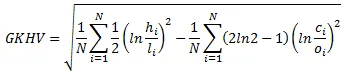

The Garman-Klass volatility estimator calculates volatility using high, low, open, and close prices, offering up to eight times more efficiency than the close-to-close estimator, though it is more biased than the Parkinson method.

In [28]:
# Calculate the Garman-Klass volatility estimator and store in 'gkv' column
df['gkv'] = ((np.log(df['high']) - np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['adj close']) - np.log(df['open']))**2)

## Relative Strength Index (RSI)

The Relative Strength Index (RSI) is a momentum indicator that evaluates price changes to identify overbought (70+) or oversold (30-) conditions. Developed by J. Welles Wilder Jr., it helps signal potential trend reversals, with a standard 14-period calculation using average gains and losses.

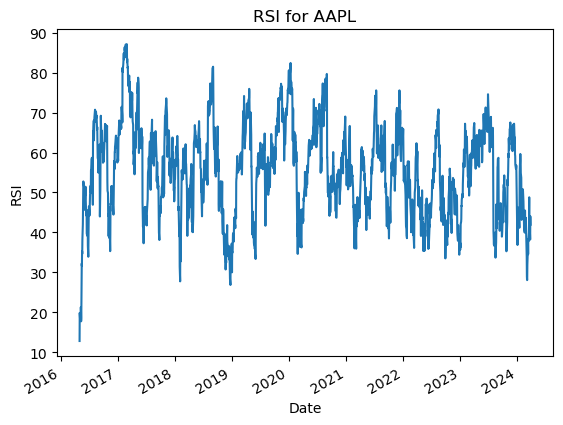

In [30]:
# Calculate the RSI for each stock and plot the RSI for AAPL
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.rsi(close=x, length=20))
ax = df.xs('AAPL', level=1)['rsi'].plot()
ax.set_xlabel("Date")
ax.set_ylabel("RSI")
ax.set_title("RSI for AAPL");


## Bollinger Bands

Bollinger Bands are a technical analysis tool developed by John Bollinger that help gauge volatility. The bands consist of a 20-day simple moving average (SMA) with upper and lower bands set two standard deviations above and below the SMA. When the bands widen, volatility increases; when they contract, it decreases. Traders use Bollinger Bands to identify overbought and oversold conditions, trend strength, and potential breakouts. They are most effective when used with other indicators

In [32]:
# Calculate the lower, middle, and upper Bollinger Bands for each stock based on the log-transformed adjusted close price
df['bblow'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:, 0])
df['bbmid'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:, 1])
df['bbhigh'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:, 2])

## Average True Range (ATR)

ATR measures market volatility by calculating the greatest of three price ranges and averaging them over 14 days. It helps gauge volatility but doesn't indicate price direction, often used for exit points and risk management.

In [33]:
# Compute the ATR (Average True Range), normalize it 
#by subtracting the mean and dividing by the standard deviation, for each stock in the dataframe

def compute_atr(data):
    atr = ta.atr(high=data['high'], 
                 low=data['low'], 
                 close=data['close'], 
                 length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

## Moving Average Convergence Divergence (MACD)

MACD identifies price trends and momentum by comparing the 12-period and 26-period EMAs. We use MACD crossovers, divergences, and rapid moves to generate buy or sell signals

In [36]:
# Compute normalized MACD for each stock in the dataframe

def compute_MACD(close):
    macd = ta.macd(close=close, length=20).iloc[:, 0]  # Corrected indexing
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_MACD)

## Dollar Volume Liquidity

Dollar volume liquidity is the product of a stock's price and daily trading volume, indicating how easily large trades can be made without impacting the price. It's crucial for institutional investors, as higher dollar volume typically lowers the bid-ask spread and improves trade execution.

In [38]:
# Calculate dollar volume (in millions) for each stock
df['dv'] = (df['adj close'] * df['volume'])/1e6
#df

Price                              adj close       close        high  \
Date                      Ticker                                       
2016-04-04 00:00:00+00:00 A        37.475124   40.009998   40.520000   
                          AAL      37.726421   39.369999   40.240002   
                          AAPL     25.331829   27.780001   28.047501   
                          ABBV     41.183521   59.209999   59.400002   
                          ABT      36.113205   42.320000   42.669998   
...                                      ...         ...         ...   
2024-03-28 00:00:00+00:00 XYL     128.561066  129.240005  130.220001   
                          YUM     137.286957  138.649994  138.830002   
                          ZBH     131.687302  131.979996  133.899994   
                          ZBRA    301.440002  301.440002  302.630005   
                          ZTS     168.328522  169.210007  171.139999   

Price                                    low        open       volume  \
Date                      Ticker                                        
2016-04-04 00:00:00+00:00 A        39.799999   40.320000    2958100.0   
                          AAL      39.150002   39.810001    7831200.0   
                          AAPL     27.567499   27.605000  149424800.0   
                          ABBV     57.490002   57.639999    8108100.0   
                          ABT      42.160000   42.340000    4407800.0   
...                                      ...         ...          ...   
2024-03-28 00:00:00+00:00 XYL     129.149994  129.559998     953200.0   
                          YUM     137.389999  137.389999    1770900.0   
                          ZBH     131.600006  132.929993    1425300.0   
                          ZBRA    298.040009  300.239990     376900.0   
                          ZTS     167.410004  168.729996    3395600.0   

Price                                  gkv        rsi     bblow     bbmid  \
Date                      Ticker                                            
2016-04-04 00:00:00+00:00 A      -0.001907        NaN       NaN       NaN   
                          AAL    -0.000739        NaN       NaN       NaN   
                          AAPL   -0.002704        NaN       NaN       NaN   
                          ABBV   -0.043123        NaN       NaN       NaN   
                          ABT    -0.009703        NaN       NaN       NaN   
...                                    ...        ...       ...       ...   
2024-03-28 00:00:00+00:00 XYL     0.000011  64.013549  4.837753  4.853933   
                          YUM     0.000054  58.411374  4.898436  4.923007   
                          ZBH     0.000116  64.609399  4.816000  4.848710   
                          ZBRA    0.000111  62.620998  5.629442  5.668904   
                          ZTS     0.000241  36.439484  5.086661  5.170550   

Price                               bbhigh       atr      macd           dv  
Date                      Ticker                                             
2016-04-04 00:00:00+00:00 A            NaN       NaN       NaN   110.855165  
                          AAL          NaN       NaN       NaN   295.443151  
                          AAPL         NaN       NaN       NaN  3785.203493  
                          ABBV         NaN       NaN       NaN   333.920109  
                          ABT          NaN       NaN       NaN   159.179785  
...                                    ...       ...       ...          ...  
2024-03-28 00:00:00+00:00 XYL     4.870113 -0.272662  0.832538   122.544408  
                          YUM     4.947577 -0.044518  0.120086   243.121472  
                          ZBH     4.881421 -0.655308  0.537839   187.693911  
                          ZBRA    5.708366  0.016500  0.823688   113.612737  
                          ZTS     5.254439  0.908825 -2.766863   571.576328  

[984258 rows x 14 columns]

## Consolidate stock data on a monthly basis and select the 150 most liquid stocks for each month
Aggregating stock data monthly, specifically focusing on month-end frequency rather than day-to-day data, reduces noise from daily fluctuations and highlights long-term trends. By selecting the top 150 most liquid stocks for each month, we further enhance the model's focus on stable, significant patterns. This approach simplifies the dataset, improves feature engineering, reduces training time, and boosts the machine learning model's predictive accuracy by focusing on meaningful, less volatile data.

In [118]:
#Resample data to monthly frequency, calculate mean for dollar volume and other relevant columns
#Then stack and combine into one DataFrame

last_columns = [c for c in df.columns.unique(0) if c not in ['dv','volume','open','high','low','close']]
#last_columns
data = pd.concat([
    df.unstack('Ticker')['dv'].resample('M').mean().stack('Ticker').to_frame('dv'),
    df.unstack('Ticker')[last_columns].resample('M').mean().stack('Ticker')
], axis=1).dropna()

#data

dv   adj close       gkv  \
Date                      Ticker                                      
2016-05-31 00:00:00+00:00 A        104.362546   40.603958 -0.001392   
                          AAL      304.648988   31.261631 -0.000450   
                          AAPL    3728.203351   21.764342 -0.002793   
                          ABBV     423.920577   43.305737 -0.047276   
                          ABT      394.766596   32.790862 -0.008892   
...                                       ...         ...       ...   
2024-03-31 00:00:00+00:00 ABNB     729.258040  164.105500  0.000233   
                          CEG      490.784630  174.285531  0.000612   
                          GEHC     338.987134   90.919768  0.000148   
                          KVUE     367.805047   19.791835  0.000114   
                          VLTO     140.788400   88.362190  0.000129   

                                        rsi     bblow     bbmid    bbhigh  \
Date                      Ticker                                            
2016-05-31 00:00:00+00:00 A       66.053883  3.647779  3.693345  3.738911   
                          AAL     26.913817  3.430852  3.549723  3.668594   
                          AAPL    31.041911  3.059898  3.154481  3.249065   
                          ABBV    59.540283  3.746503  3.783653  3.820803   
                          ABT     30.059170  3.476025  3.569542  3.663059   
...                                     ...       ...       ...       ...   
2024-03-31 00:00:00+00:00 ABNB    60.818495  5.004696  5.066644  5.128593   
                          CEG     73.687802  4.858802  5.055783  5.252763   
                          GEHC    62.913204  4.437948  4.505158  4.572368   
                          KVUE    54.617807  2.952802  3.001636  3.050469   
                          VLTO    62.678698  4.436702  4.474803  4.512904   

                                       atr      macd  
Date                      Ticker                      
2016-05-31 00:00:00+00:00 A      -1.265836  0.226667  
                          AAL     0.340070 -2.448528  
                          AAPL   -1.103300 -0.741222  
                          ABBV   -1.053068  0.022477  
                          ABT    -1.076552 -1.361154  
...                                    ...       ...  
2024-03-31 00:00:00+00:00 ABNB   -0.646116  0.876829  
                          CEG     3.950697  3.649380  
                          GEHC    0.556623  1.146834  
                          KVUE   -1.129213  0.714750  
                          VLTO   -0.856429  0.775572  

[46494 rows x 9 columns]

## 5-Year Rolling Average Dollar Volume for each stock 

In [124]:
# Apply a rolling 5-year mean for 'dv' using groupby 
# and transform with a minimum of 1 period
data['dv_rolling'] = data.groupby('Ticker')['dv'].transform(lambda x: x.rolling(window=5*12, min_periods=1).mean())

In [136]:
# Rank 'dv_rolling' within each Date and filter top 150
# Drop the 'dv' and 'dv_rolling' columns
data['dv_rank'] = data.groupby('Date')['dv_rolling'].rank(ascending=False)
data = data[data['dv_rank'] < 150].drop(columns=['dv', 'dv_rolling'],axis =1)
data

adj close       gkv        rsi     bblow  \
Date                      Ticker                                              
2016-05-31 00:00:00+00:00 AAL      31.261631 -0.000450  26.913817  3.430852   
                          AAPL     21.764342 -0.002793  31.041911  3.059898   
                          ABBV     43.305737 -0.047276  59.540283  3.746503   
                          ABT      32.790862 -0.008892  30.059170  3.476025   
                          ACN     102.164066 -0.006189  55.896493  4.603429   
...                                      ...       ...        ...       ...   
2024-03-31 00:00:00+00:00 MRNA    104.018500  0.000800  55.962061  4.475597   
                          UBER     78.512500  0.000342  60.636567  4.306370   
                          CRWD    322.727998  0.000763  55.520236  5.711042   
                          ABNB    164.105500  0.000233  60.818495  5.004696   
                          KVUE     19.791835  0.000114  54.617807  2.952802   

                                     bbmid    bbhigh       atr      macd  \
Date                      Ticker                                           
2016-05-31 00:00:00+00:00 AAL     3.549723  3.668594  0.340070 -2.448528   
                          AAPL    3.154481  3.249065 -1.103300 -0.741222   
                          ABBV    3.783653  3.820803 -1.053068  0.022477   
                          ABT     3.569542  3.663059 -1.076552 -1.361154   
                          ACN     4.624463  4.645497 -1.099118 -0.073075   
...                                    ...       ...       ...       ...   
2024-03-31 00:00:00+00:00 MRNA    4.589197  4.702796 -0.428127  0.161091   
                          UBER    4.366798  4.427226  1.323995  1.393035   
                          CRWD    5.771899  5.832756  2.222080  0.586411   
                          ABNB    5.066644  5.128593 -0.646116  0.876829   
                          KVUE    3.001636  3.050469 -1.129213  0.714750   

                                  dv_rank  
Date                      Ticker           
2016-05-31 00:00:00+00:00 AAL        69.0  
                          AAPL        1.0  
                          ABBV       36.0  
                          ABT        41.0  
                          ACN       141.0  
...                                   ...  
2024-03-31 00:00:00+00:00 MRNA       21.0  
                          UBER       34.0  
                          CRWD       60.0  
                          ABNB       39.0  
                          KVUE      100.0  

[14155 rows x 9 columns]

## Calculate Monthly Returns for Different Time Horizons and Features


In [155]:
# Calculate returns for multiple time lags, handling outliers
# Apply return calculation to the grouped data and drop missing values

def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]
    
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                       upper=x.quantile(1 - outlier_cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1)
                               )
    return df

# Apply the function to the grouped data
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data


adj close       gkv        rsi     bblow  \
Date                      Ticker                                              
2017-05-31 00:00:00+00:00 AAL      44.570760  0.000036  55.409224  3.730196   
                          AAPL     35.530707 -0.001654  68.900532  3.518561   
                          ABBV     48.252326 -0.038358  58.421618  3.861517   
                          ABT      38.769448 -0.006153  51.929706  3.657613   
                          ACN     109.103888 -0.004502  56.942384  4.661558   
...                                      ...       ...        ...       ...   
2024-03-31 00:00:00+00:00 XOM     108.880917  0.000022  66.749407  4.611962   
                          MRNA    104.018500  0.000800  55.962061  4.475597   
                          UBER     78.512500  0.000342  60.636567  4.306370   
                          CRWD    322.727998  0.000763  55.520236  5.711042   
                          ABNB    164.105500  0.000233  60.818495  5.004696   

                                     bbmid    bbhigh       atr      macd  \
Date                      Ticker                                           
2017-05-31 00:00:00+00:00 AAL     3.794805  3.859415  0.743574  0.779618   
                          AAPL    3.566238  3.613914 -1.145498  0.034192   
                          ABBV    3.888308  3.915099 -1.488440 -0.086527   
                          ABT     3.678339  3.699064 -1.399329 -0.219895   
                          ACN     4.686656  4.711755 -1.199885 -0.080730   
...                                    ...       ...       ...       ...   
2024-03-31 00:00:00+00:00 XOM     4.658951  4.705941  0.091294  1.572965   
                          MRNA    4.589197  4.702796 -0.428127  0.161091   
                          UBER    4.366798  4.427226  1.323995  1.393035   
                          CRWD    5.771899  5.832756  2.222080  0.586411   
                          ABNB    5.066644  5.128593 -0.646116  0.876829   

                                  dv_rank  return_1m  return_2m  return_3m  \
Date                      Ticker                                             
2017-05-31 00:00:00+00:00 AAL        75.0   0.052724   0.034969   0.000331   
                          AAPL        1.0   0.068198   0.041842   0.045557   
                          ABBV       67.0   0.025869   0.013128   0.029665   
                          ABT        71.0   0.010016  -0.008315   0.003848   
                          ACN       109.0   0.036724  -0.000304   0.011582   
...                                   ...        ...        ...        ...   
2024-03-31 00:00:00+00:00 XOM        17.0   0.077030   0.054993   0.034829   
                          MRNA       21.0   0.116881  -0.004837   0.062908   
                          UBER       34.0   0.055205   0.117445   0.086121   
                          CRWD       60.0   0.017684   0.073589   0.088443   
                          ABNB       39.0   0.090911   0.081931   0.053522   

                                  return_6m  return_9m  return_12m  
Date                      Ticker                                    
2017-05-31 00:00:00+00:00 AAL      0.008779   0.029691    0.029998  
                          AAPL     0.056710   0.040711    0.041689  
                          ABBV     0.019251   0.003234    0.009054  
                          ABT      0.021058   0.001449    0.014055  
                          ACN      0.005869   0.009800    0.005492  
...                                     ...        ...         ...  
2024-03-31 00:00:00+00:00 XOM     -0.005186   0.008341    0.005590  
                          MRNA    -0.002126  -0.019871   -0.028154  
                          UBER     0.091231   0.072302    0.076500  
                          CRWD     0.117638   0.088990    0.079478  
                          ABNB     0.027214   0.032564    0.026123  

[11884 rows x 15 columns]

## Download Fama-French Factors and Calculate Rolling Factor Betas
Asses performance using linear regression

Fama-French Factors, which account for market risk, size, value, operating profitability, and investment, have been empirically shown to capture the risk/return characteristics of portfolios. Incorporating historical factor exposures helps enhance portfolio analysis.

We can access these historical factor returns using pandas-datareader and estimate past exposure by applying a rolling OLS regression model (RollingOLS).

In [222]:
# Load Fama-French factors data, drop risk-free rate (RF)
# Convert the index to timestamp, resample to monthly, and adjust by dividing by 100
# Remove timezone from the 'Date' level of the MultiIndex in 'data'
# Join Fama-French factors data with 'return_1m' from 'data'


factor_data = web.DataReader('F-F_Research_data_5_Factors_2x3',
                              'famafrench',
                             start = '2010')[0].drop('RF', axis = 1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'Date'
factor_data
Fix the Date level of the MultiIndex by localizing or removing the timezone
data.index = pd.MultiIndex.from_arrays([
    pd.DatetimeIndex(data.index.get_level_values('Date')).tz_localize(None),  # Remove timezone info from 'Date'
    data.index.get_level_values('Ticker')
])
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
Date       Ticker                                                   
2017-05-31 AAL     0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.052724
           AAPL    0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.068198
           ABBV    0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.025869
           ABT     0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.010016
           ACN     0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.036724
...                   ...     ...     ...     ...     ...        ...
2024-03-31 VRTX    0.0283 -0.0118  0.0421  0.0147  0.0119  -0.020541
           VZ      0.0283 -0.0118  0.0421  0.0147  0.0119  -0.006878
           WFC     0.0283 -0.0118  0.0421  0.0147  0.0119   0.119345
           WMT     0.0283 -0.0118  0.0421  0.0147  0.0119   0.057008
           XOM     0.0283 -0.0118  0.0421  0.0147  0.0119   0.077030

[11884 rows x 6 columns]

### Filter out stock with less than 10 months of data

In [235]:
# Group the data by 'Ticker' and count the number of observations per group
# Filter out stocks with more than 10 observations
# Keep only rows in 'factor_data' where 'Ticker' is in the valid stocks

observations = factor_data.groupby(level = 1).size()
valid_stocks = observations[observations > 10]
factor_data = factor_data[factor_data.index.get_level_values('Ticker').isin(valid_stocks.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
Date       Ticker                                                   
2017-05-31 AAL     0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.052724
           AAPL    0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.068198
           ABBV    0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.025869
           ABT     0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.010016
           ACN     0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.036724
...                   ...     ...     ...     ...     ...        ...
2024-03-31 VRTX    0.0283 -0.0118  0.0421  0.0147  0.0119  -0.020541
           VZ      0.0283 -0.0118  0.0421  0.0147  0.0119  -0.006878
           WFC     0.0283 -0.0118  0.0421  0.0147  0.0119   0.119345
           WMT     0.0283 -0.0118  0.0421  0.0147  0.0119   0.057008
           XOM     0.0283 -0.0118  0.0421  0.0147  0.0119   0.077030

[11810 rows x 6 columns]

### Calculate Rolling Factor Betas

In [259]:
# Apply RollingOLS regression for each stock's returns and factor data
# Use at least 24-month rolling window or fewer if fewer observations are available
# Drop 'const' from regression results and return betas for each stock


betas = (factor_data.groupby(level=1, group_keys=False)
                     .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                                 exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                                 window=min(24, x.shape[0]),
                                                 min_nobs=len(x.columns) + 1)
                                                 .fit(params_only=True)
                                                 .params.drop('const', axis=1))
)



In [283]:
# Join shifted betas to match with appropriate month on Ticker level
# Fill missing factor values with the mean within each Ticker
# Drop 'adj close' column and remove rows with missing values

factors = ['Mkt-RF','SMB','HML','RMW','CMA']
data = data.join(betas.groupby('Ticker').shift()) #Shift on ticker level to match betas with appropriate month
data.loc[:, factors] = data.groupby('Ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.drop('adj close', axis = 1)
data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11884 entries, (Timestamp('2017-05-31 00:00:00'), 'AAL') to (Timestamp('2024-03-31 00:00:00'), 'ABNB')
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   gkv         11884 non-null  float64
 1   rsi         11884 non-null  float64
 2   bblow       11884 non-null  float64
 3   bbmid       11884 non-null  float64
 4   bbhigh      11884 non-null  float64
 5   atr         11884 non-null  float64
 6   macd        11884 non-null  float64
 7   dv_rank     11884 non-null  float64
 8   return_1m   11884 non-null  float64
 9   return_2m   11884 non-null  float64
 10  return_3m   11884 non-null  float64
 11  return_6m   11884 non-null  float64
 12  return_9m   11884 non-null  float64
 13  return_12m  11884 non-null  float64
 14  Mkt-RF      11686 non-null  float64
 15  SMB         11686 non-null  float64
 16  HML         11686 non-null  float64
 17  RMW         11686 non-null  fl

## Feature Engineering Complete!!

# Predictive Modelling

## K-Means Clustering Algorithm for grouping stocks based on their features

We can establish pre-defined clusters later, but for now, we will use the 'k-means++' initialization, as it helps make an initial guess for centroids, which we can then use to define each cluster.

In [387]:
# Drop the 'clusters' column if it exists
# Define a function that applies KMeans clustering with 5 clusters
# Apply the clustering function to the grouped data by 'Date' after dropping missing values


from sklearn.cluster import KMeans
data = data.drop('clusters',axis=1) 
def get_clusters(df):
    df['clusters'] = KMeans(n_clusters=5, 
                            random_state=0,
                            init=initial_centroids).fit(df).labels_
    return df
#data = data.drop('dv_rank',axis=1) 
data = data.dropna().groupby('Date', group_keys=False).apply(get_clusters)
data

gkv        rsi     bblow     bbmid    bbhigh  \
Date       Ticker                                                      
2017-05-31 AAL     0.000036  55.409224  3.730196  3.794805  3.859415   
           AAPL   -0.001654  68.900532  3.518561  3.566238  3.613914   
           ABBV   -0.038358  58.421618  3.861517  3.888308  3.915099   
           ABT    -0.006153  51.929706  3.657613  3.678339  3.699064   
           ACN    -0.004502  56.942384  4.661558  4.686656  4.711755   
...                     ...        ...       ...       ...       ...   
2024-03-31 XOM     0.000022  66.749407  4.611962  4.658951  4.705941   
           MRNA    0.000800  55.962061  4.475597  4.589197  4.702796   
           UBER    0.000342  60.636567  4.306370  4.366798  4.427226   
           CRWD    0.000763  55.520236  5.711042  5.771899  5.832756   
           ABNB    0.000233  60.818495  5.004696  5.066644  5.128593   

                        atr      macd  return_1m  return_2m  return_3m  \
Date       Ticker                                                        
2017-05-31 AAL     0.743574  0.779618   0.052724   0.034969   0.000331   
           AAPL   -1.145498  0.034192   0.068198   0.041842   0.045557   
           ABBV   -1.488440 -0.086527   0.025869   0.013128   0.029665   
           ABT    -1.399329 -0.219895   0.010016  -0.008315   0.003848   
           ACN    -1.199885 -0.080730   0.036724  -0.000304   0.011582   
...                     ...       ...        ...        ...        ...   
2024-03-31 XOM     0.091294  1.572965   0.077030   0.054993   0.034829   
           MRNA   -0.428127  0.161091   0.116881  -0.004837   0.062908   
           UBER    1.323995  1.393035   0.055205   0.117445   0.086121   
           CRWD    2.222080  0.586411   0.017684   0.073589   0.088443   
           ABNB   -0.646116  0.876829   0.090911   0.081931   0.053522   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
Date       Ticker                                                         
2017-05-31 AAL      0.008779   0.029691    0.029998  0.103283  1.360179   
           AAPL     0.056710   0.040711    0.041689  0.438511  0.089539   
           ABBV     0.019251   0.003234    0.009054  0.232293  0.294014   
           ABT      0.021058   0.001449    0.014055  0.268415  0.168157   
           ACN      0.005869   0.009800    0.005492  0.384476  0.161094   
...                      ...        ...         ...       ...       ...   
2024-03-31 XOM     -0.005186   0.008341    0.005590 -0.003443  0.356132   
           MRNA    -0.002126  -0.019871   -0.028154  0.655126  1.736966   
           UBER     0.091231   0.072302    0.076500  0.129231  0.701258   
           CRWD     0.117638   0.088990    0.079478  0.225027 -0.253102   
           ABNB     0.027214   0.032564    0.026123  0.049695  1.231282   

                        HML       RMW       CMA  clusters  
Date       Ticker                                          
2017-05-31 AAL     0.704585  0.075414 -0.714871         2  
           AAPL   -0.332069  0.608559 -0.388607         4  
           ABBV    0.050578  0.009640  0.004881         2  
           ABT    -0.065267  0.305306 -0.081380         2  
           ACN    -0.126128  0.589655 -0.151352         2  
...                     ...       ...       ...       ...  
2024-03-31 XOM    -0.210751  0.551679  0.910814         4  
           MRNA   -1.577802  1.964468  1.883077         2  
           UBER   -0.265405 -2.126736 -0.513214         3  
           CRWD   -0.469839 -1.096398 -0.321664         2  
           ABNB   -0.463620 -1.199576  0.444085         3  

[11686 rows x 19 columns]

In [389]:
import matplotlib.pyplot as plt

# Define a function to plot clusters based on the ATR and RSI features
# Scatter plots are created for each cluster with different colors

def plot_clusters(data):
  
    cluster_0 = data[data['clusters'] == 0]
    cluster_1 = data[data['clusters'] == 1]
    cluster_2 = data[data['clusters'] == 2]
    cluster_3 = data[data['clusters'] == 3]
    cluster_4 = data[data['clusters'] == 4]

    # ATR and RSI are The Features being used to plot the scatter plot
    plt.scatter(cluster_0.iloc[:, 5], cluster_0.iloc[:, 1], color='red', label='Cluster 0')
    plt.scatter(cluster_1.iloc[:, 5], cluster_1.iloc[:, 1], color='green', label='Cluster 1')
    plt.scatter(cluster_2.iloc[:, 5], cluster_2.iloc[:, 1], color='blue', label='Cluster 2')
    plt.scatter(cluster_3.iloc[:, 5], cluster_3.iloc[:, 1], color='black', label='Cluster 3')
    plt.scatter(cluster_4.iloc[:, 5], cluster_4.iloc[:, 1], color='purple', label='Cluster 4')


    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()
    return


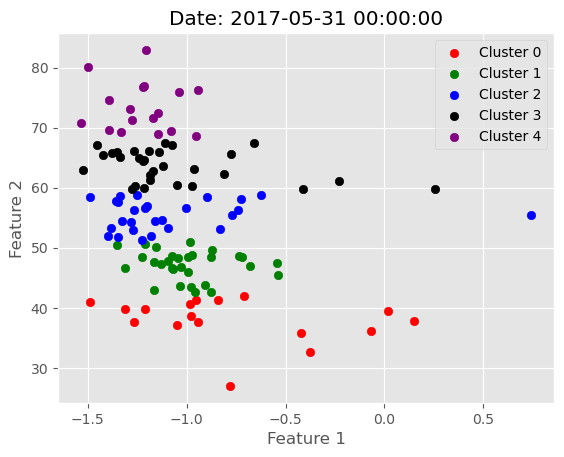

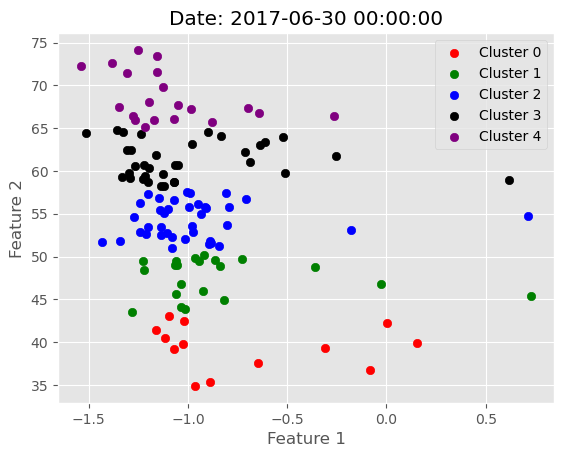

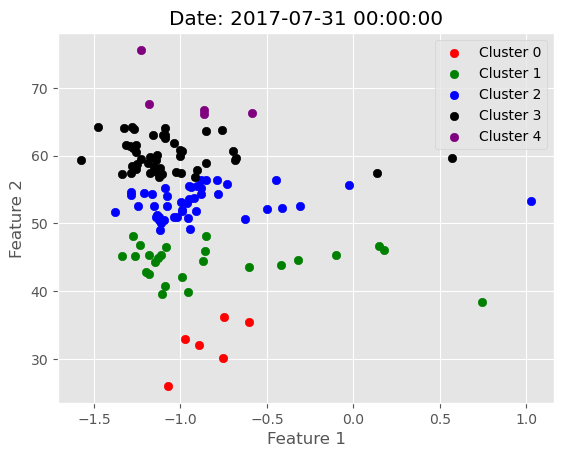

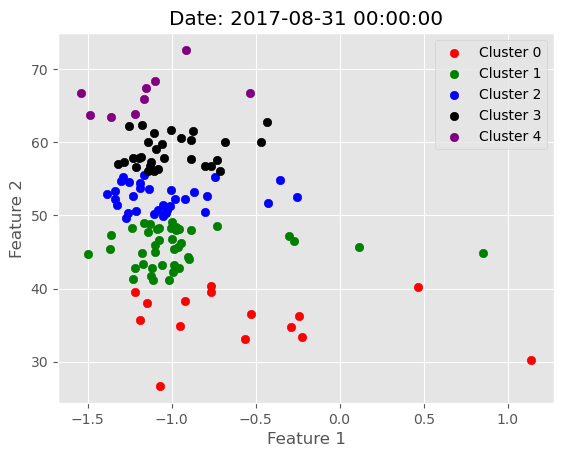

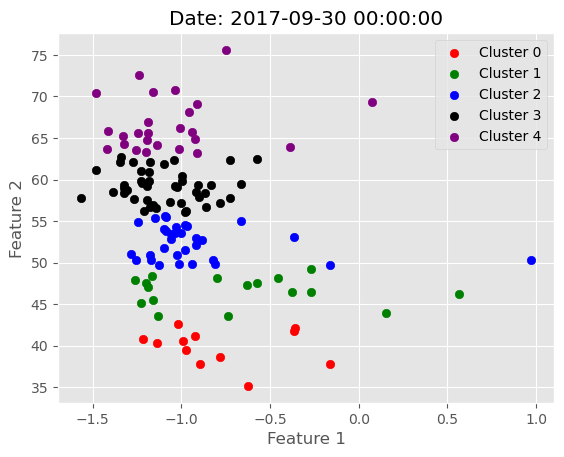

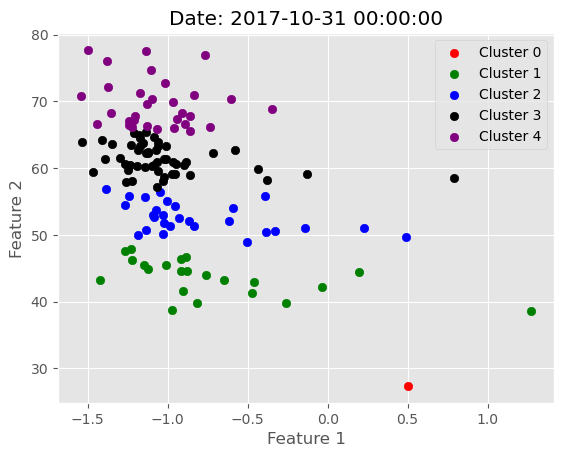

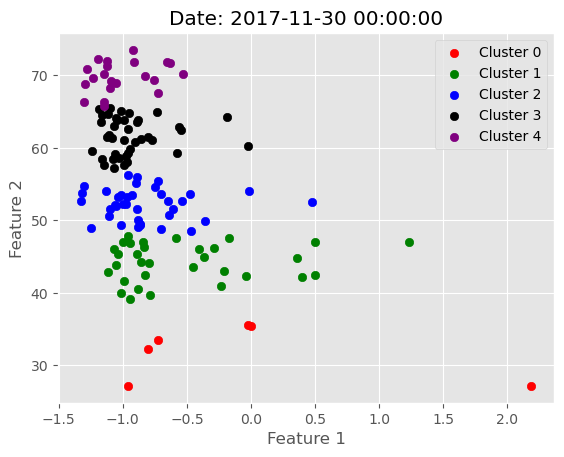

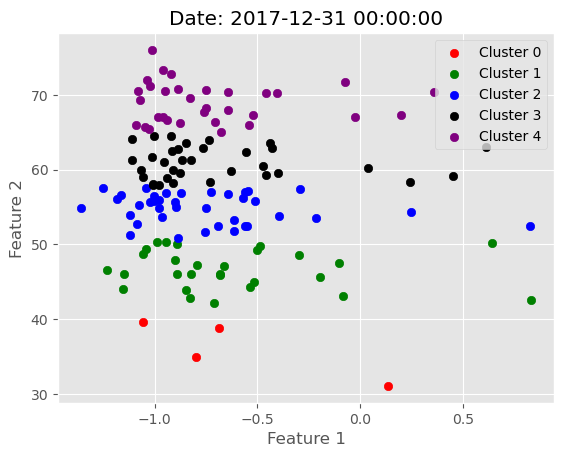

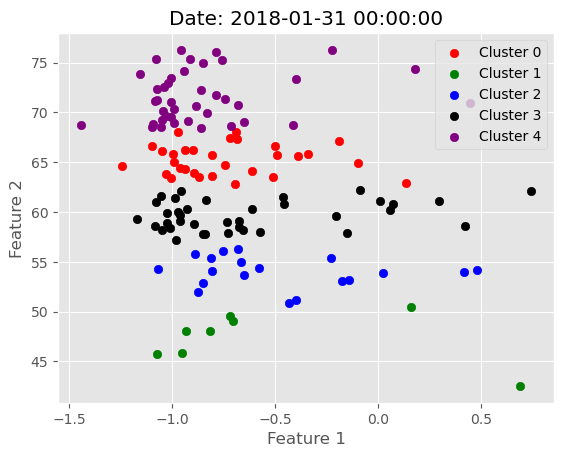

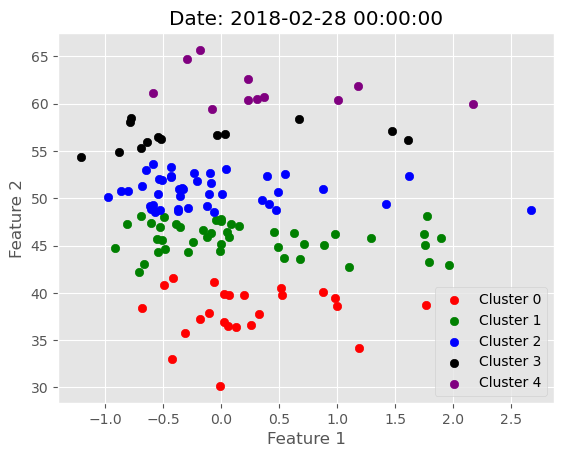

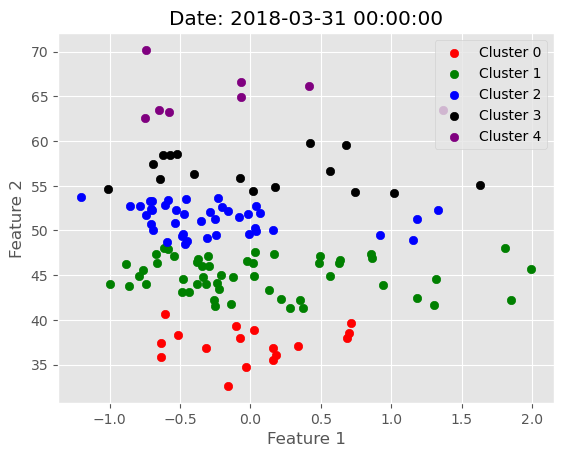

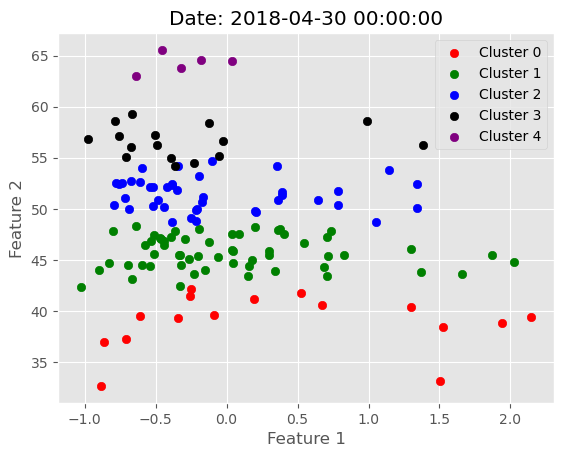

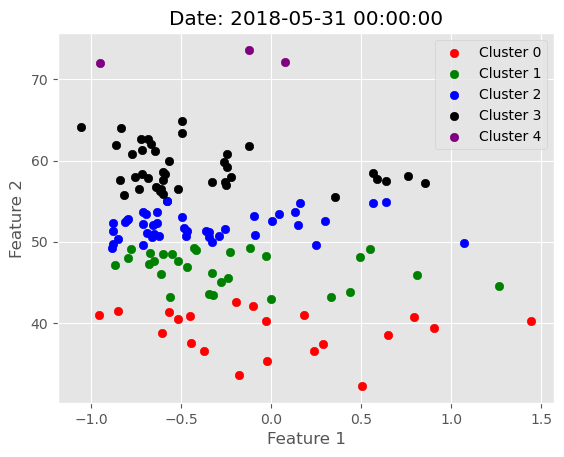

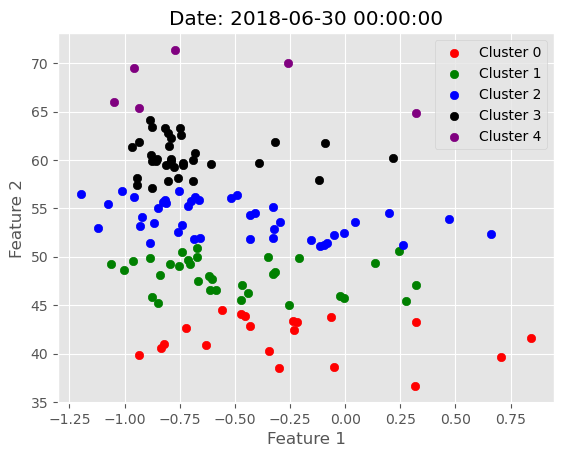

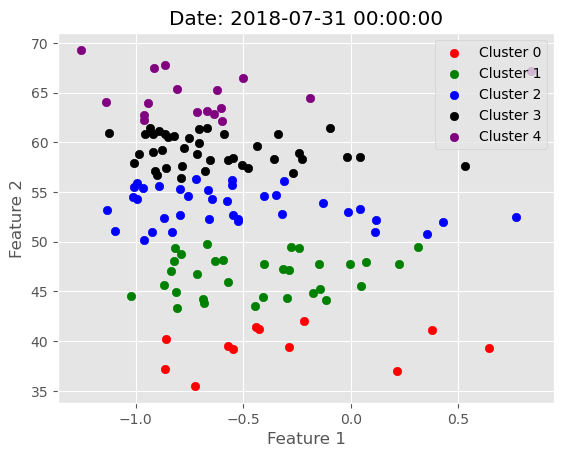

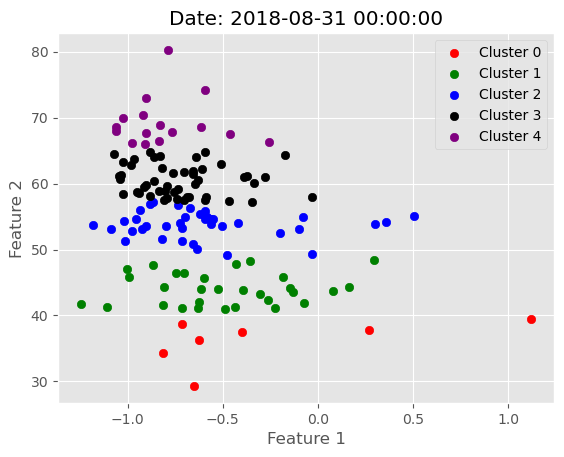

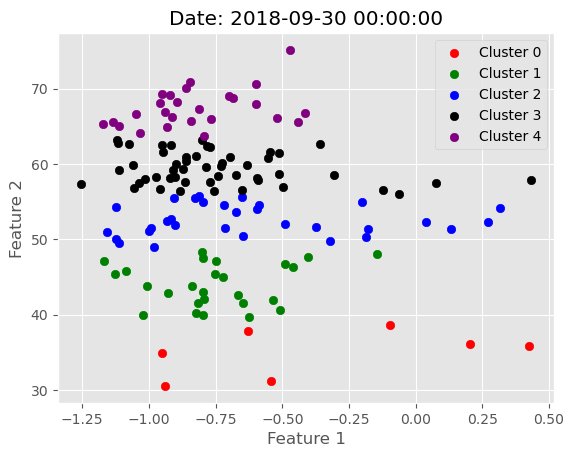

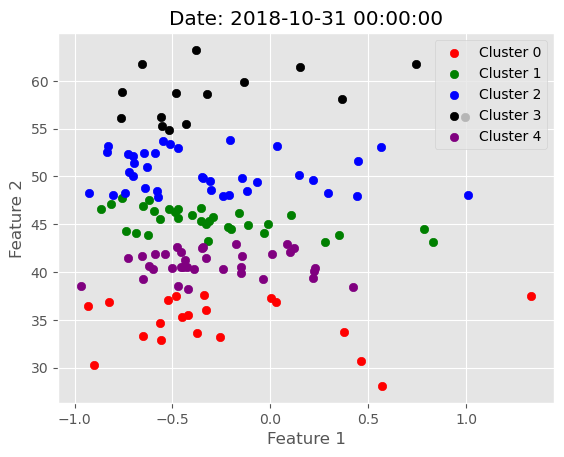

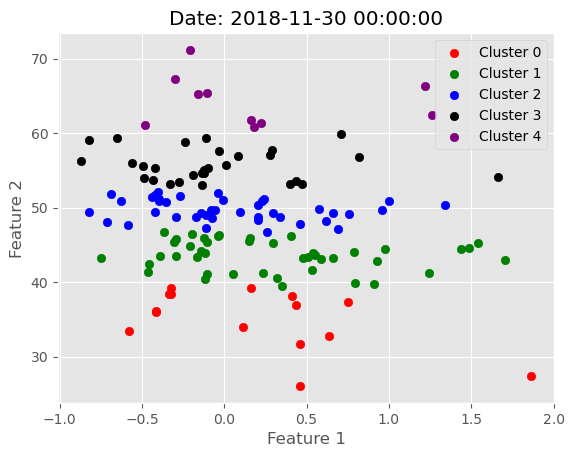

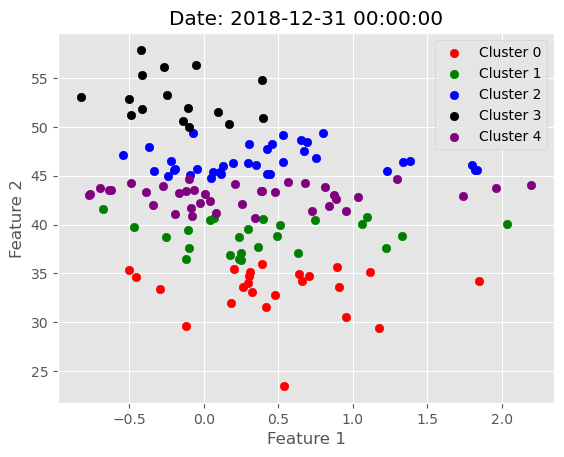

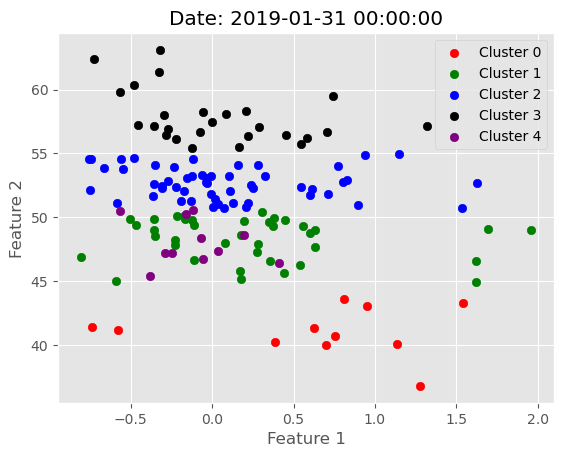

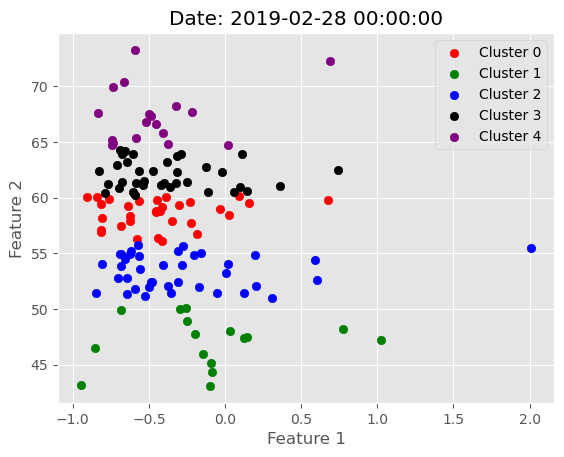

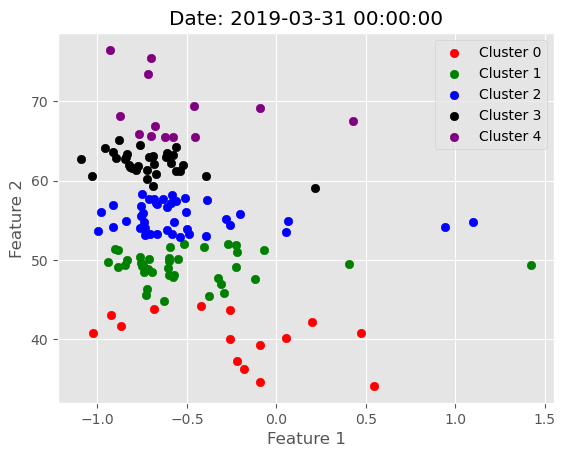

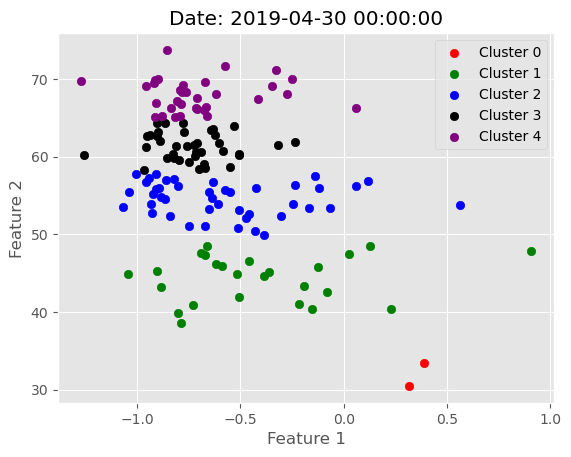

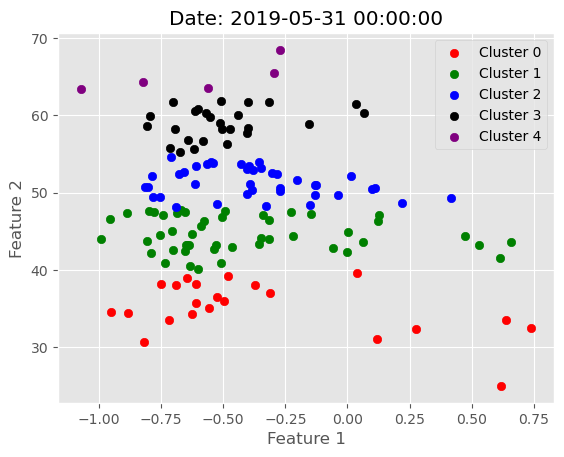

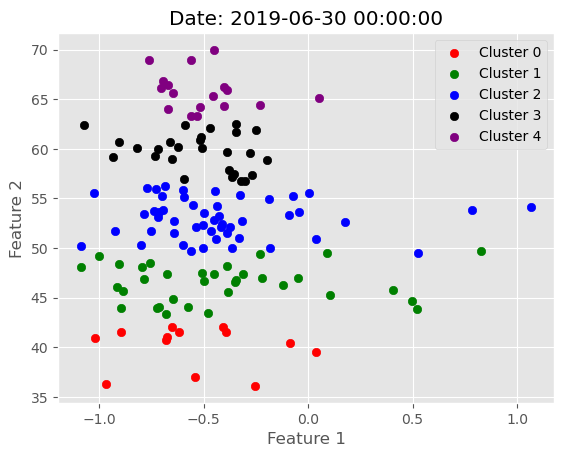

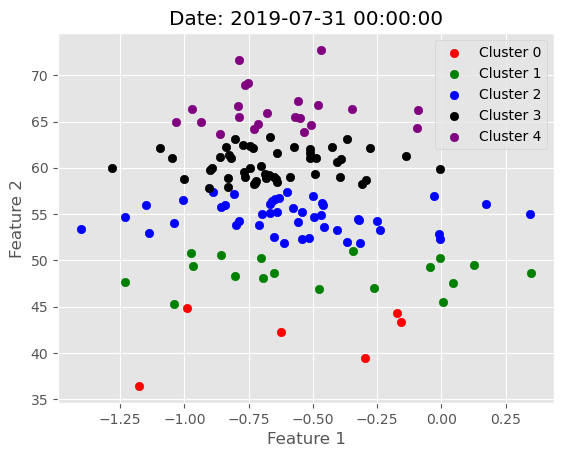

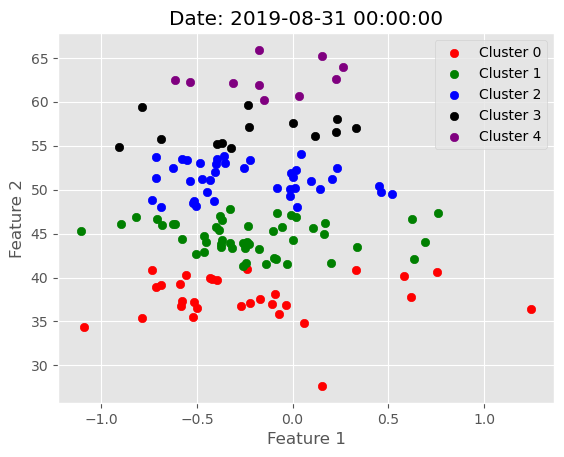

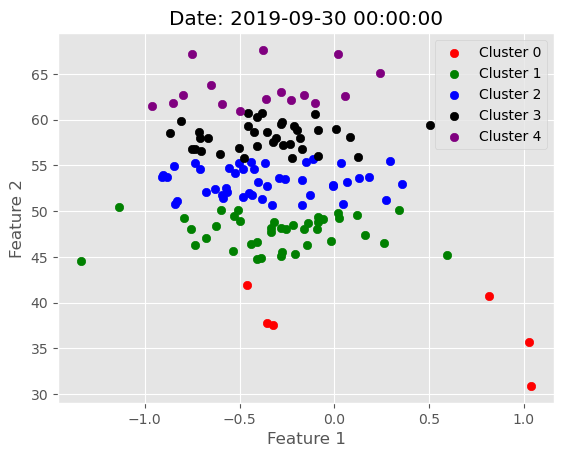

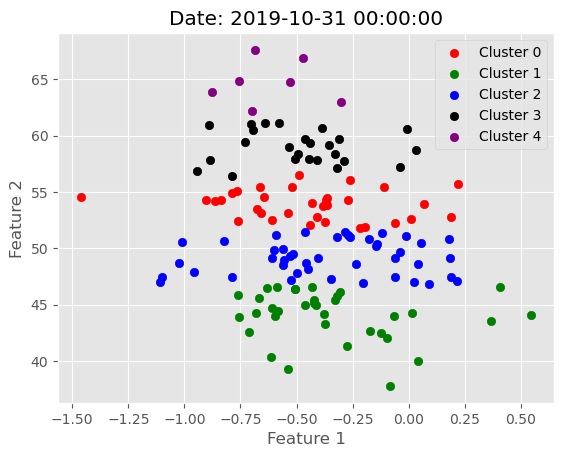

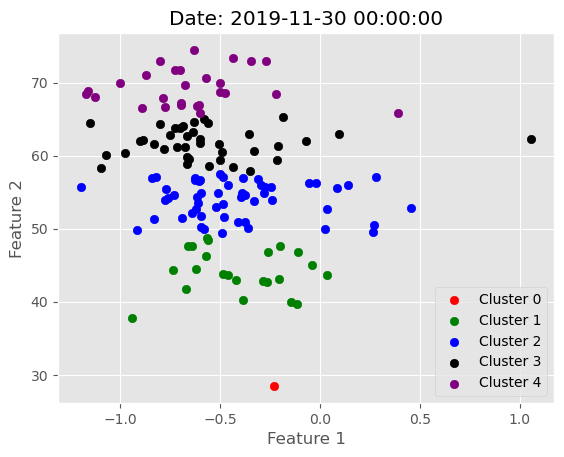

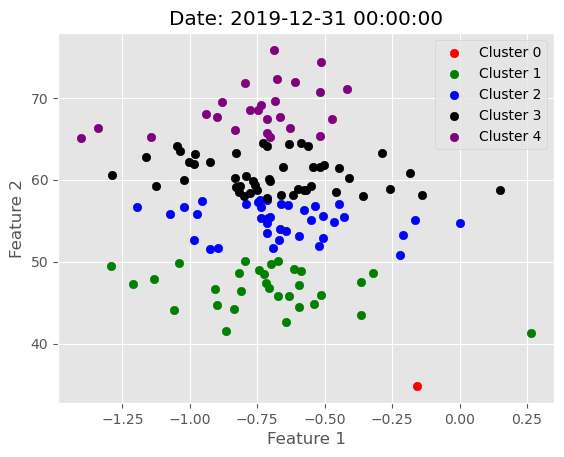

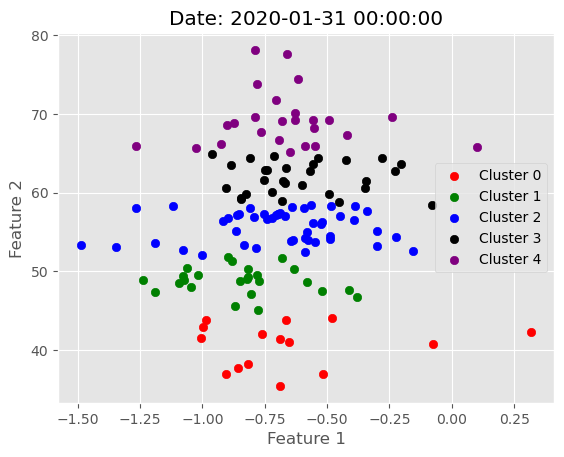

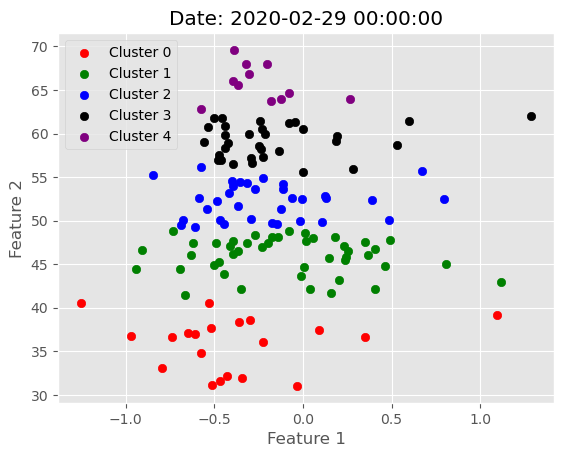

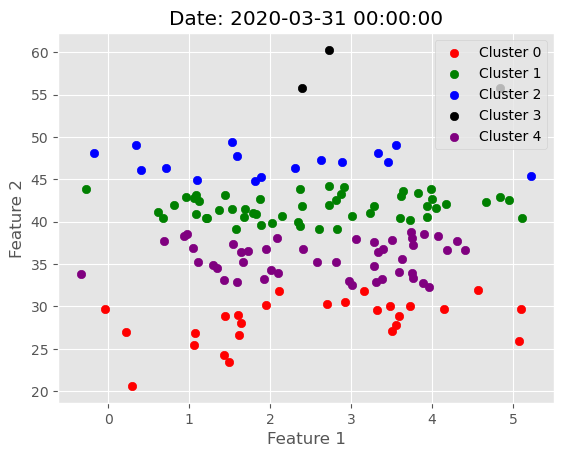

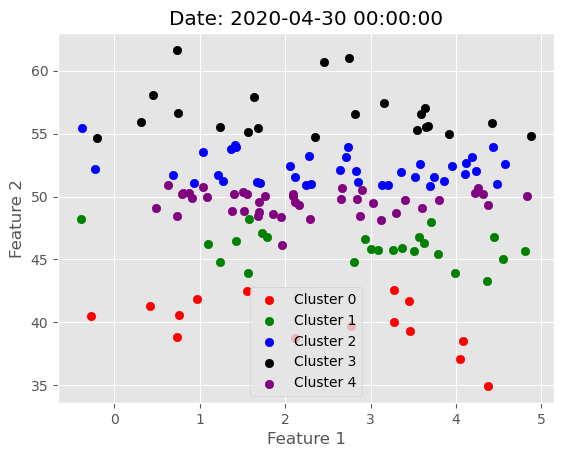

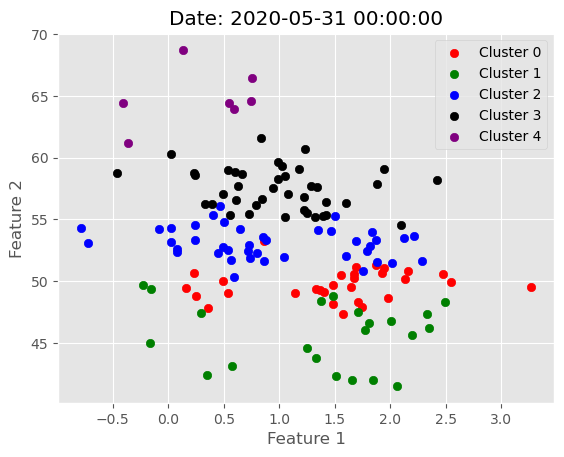

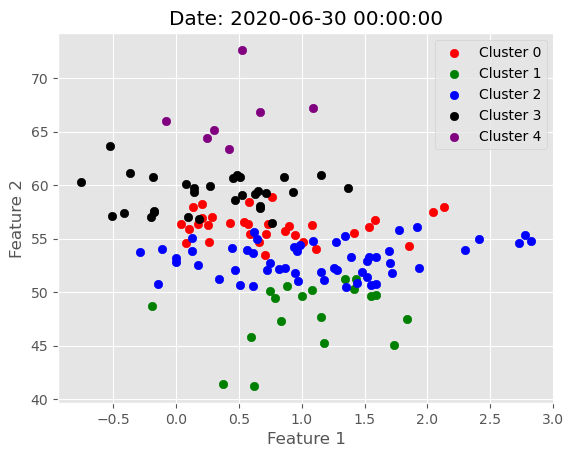

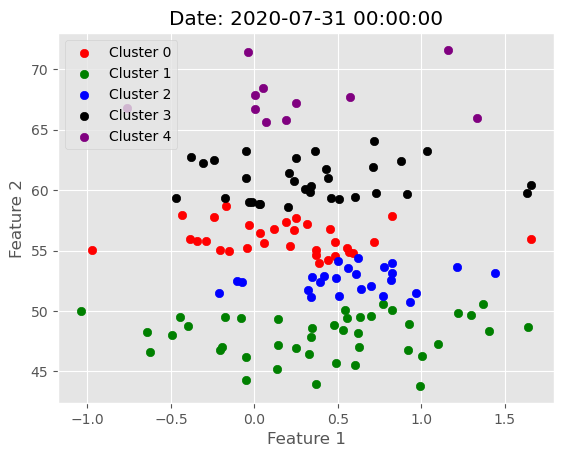

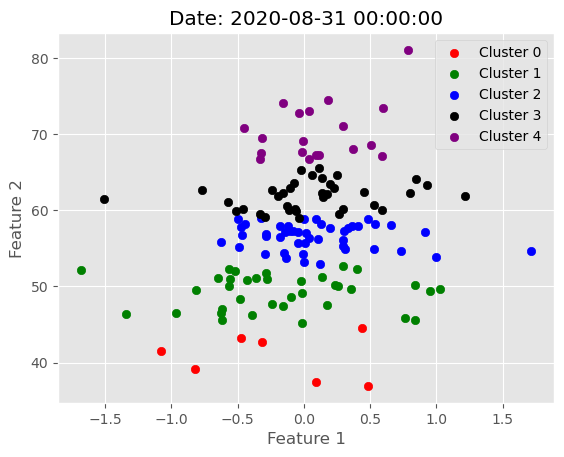

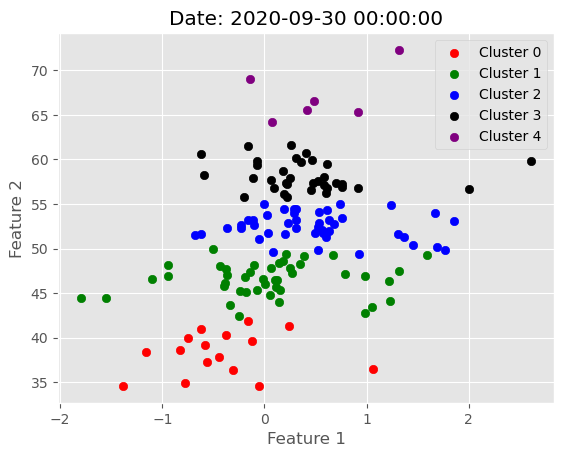

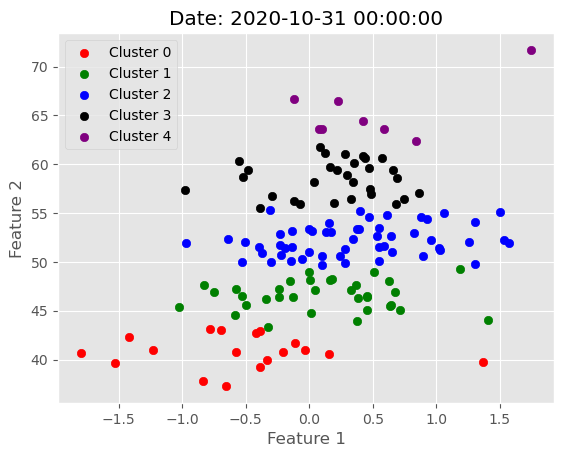

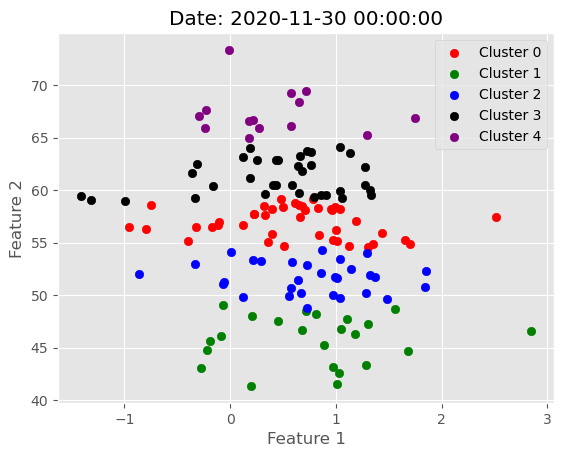

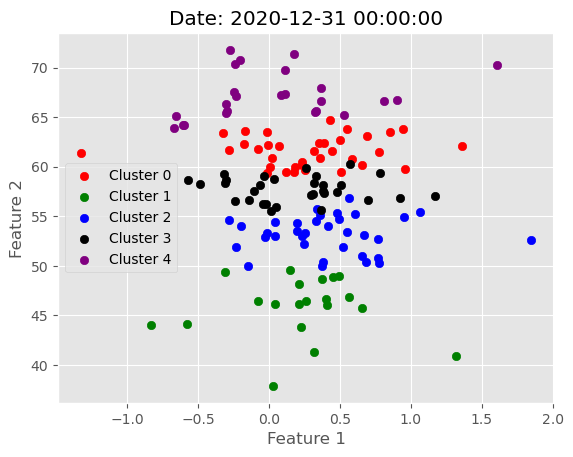

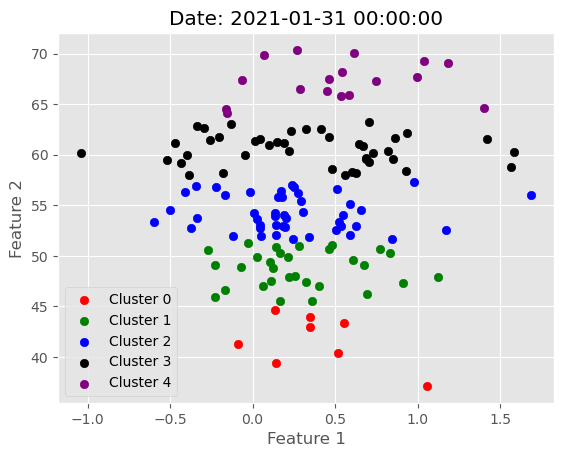

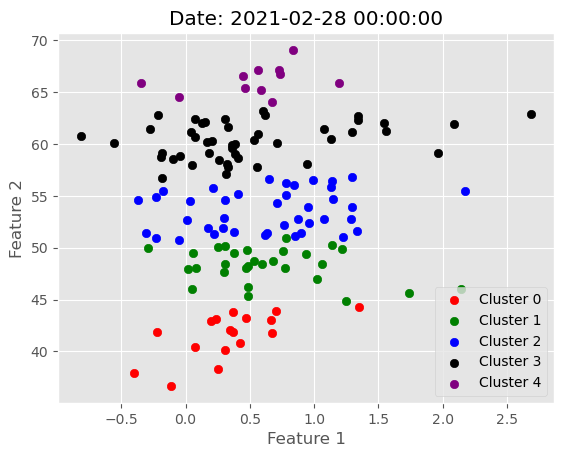

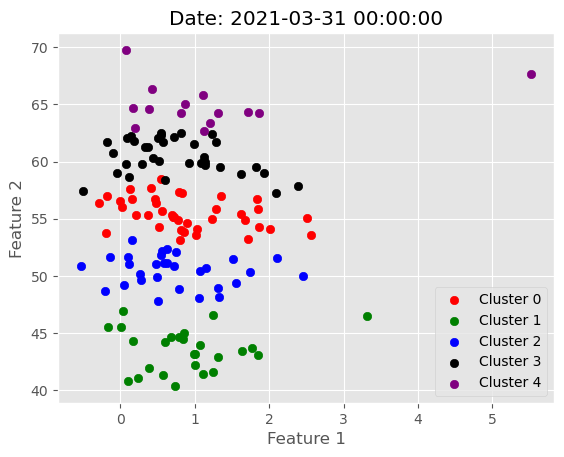

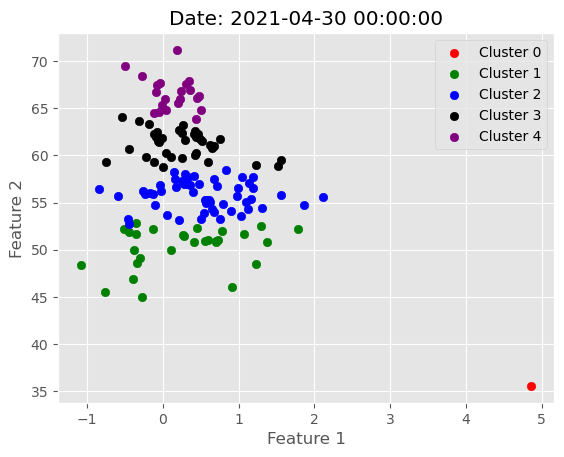

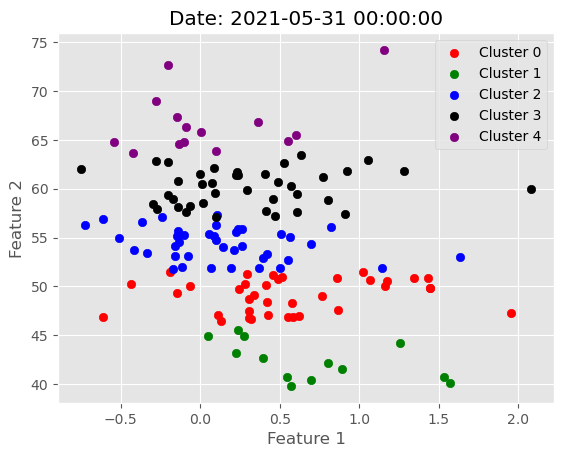

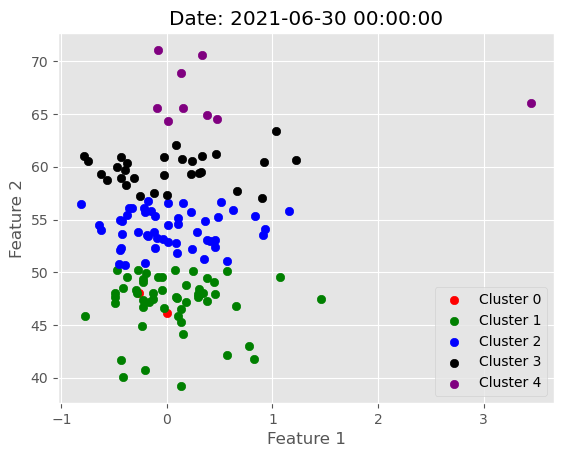

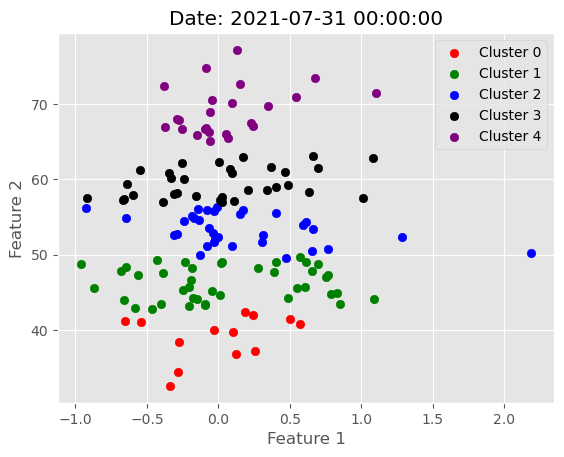

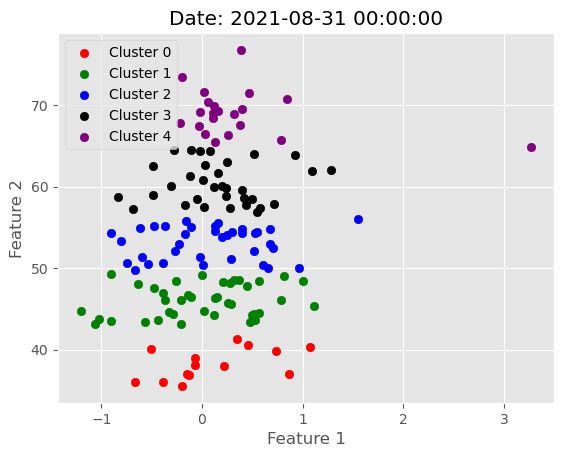

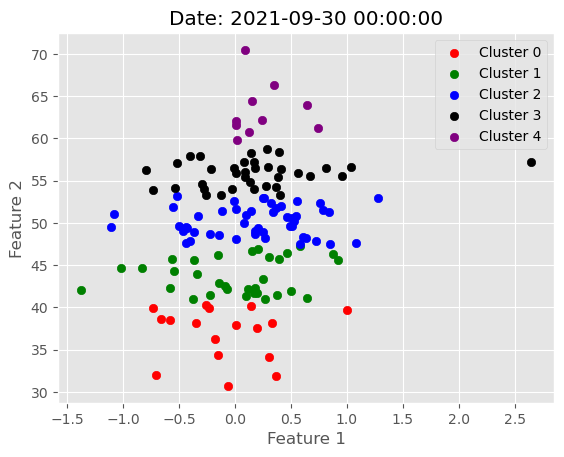

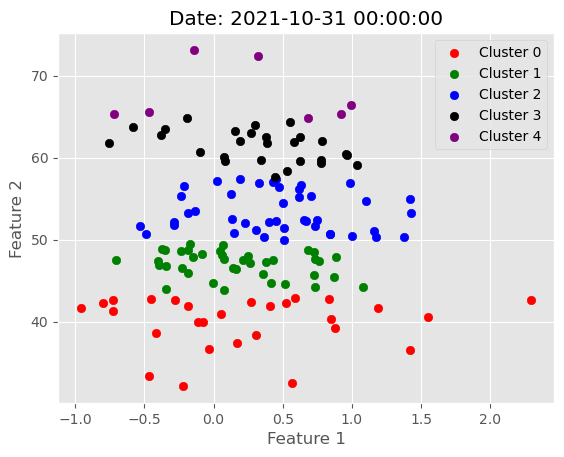

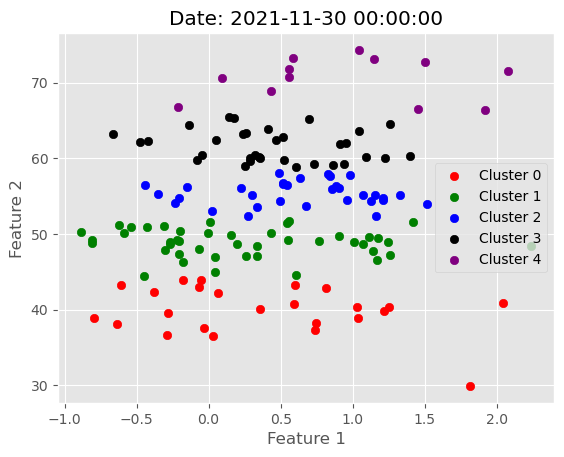

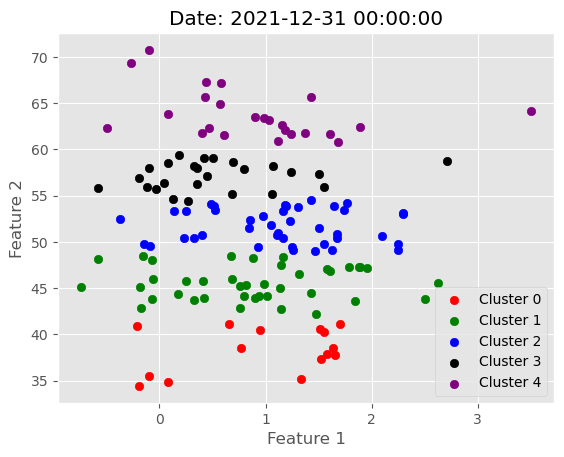

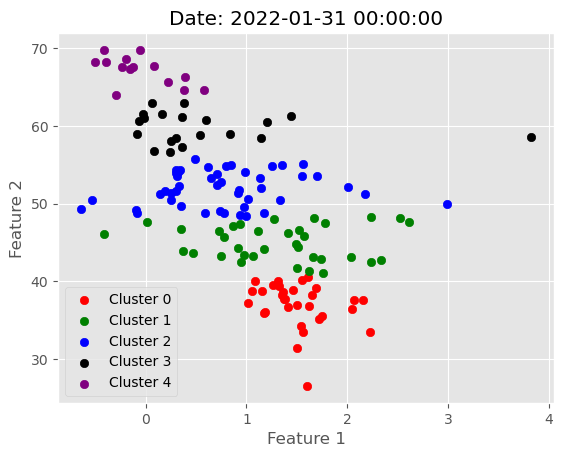

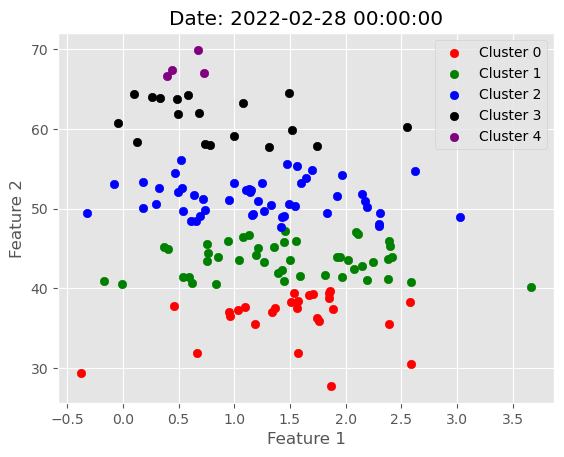

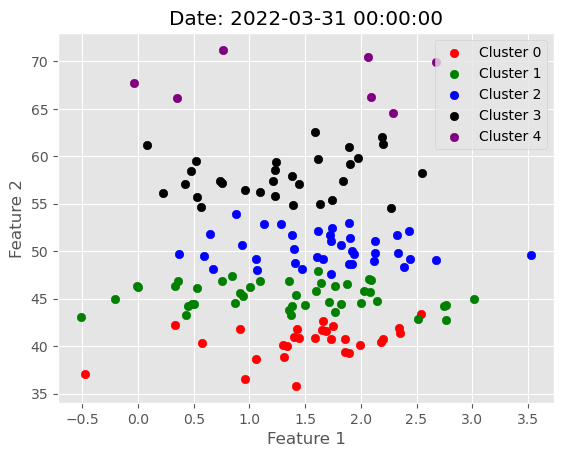

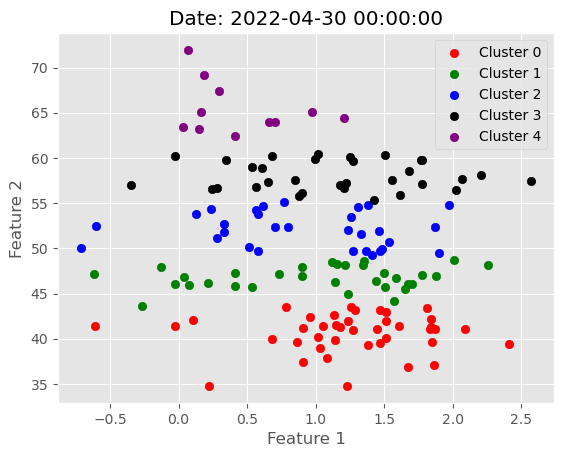

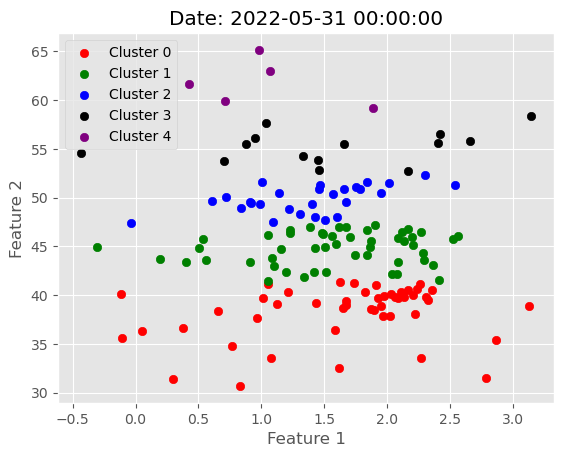

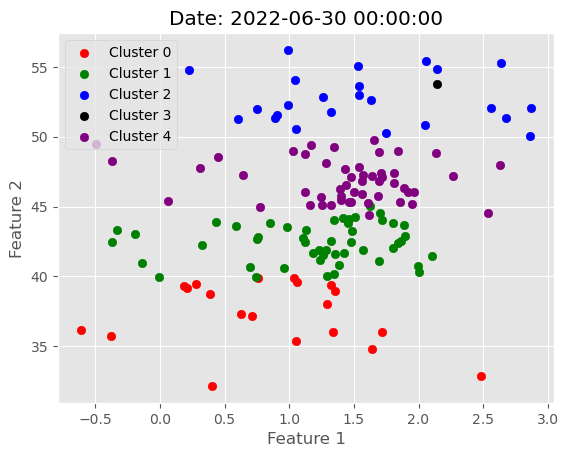

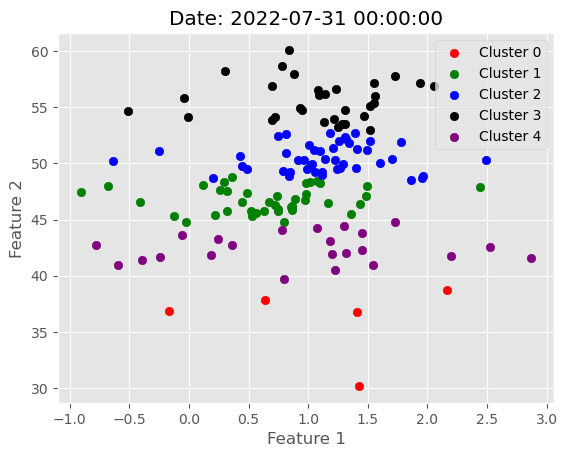

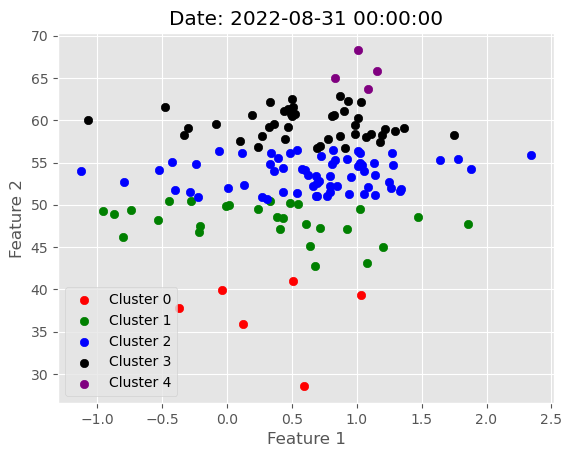

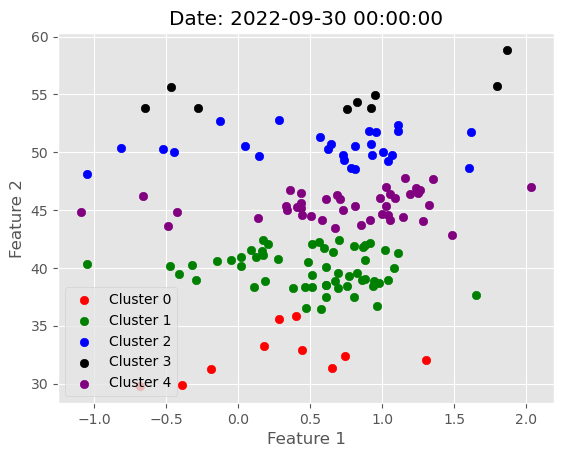

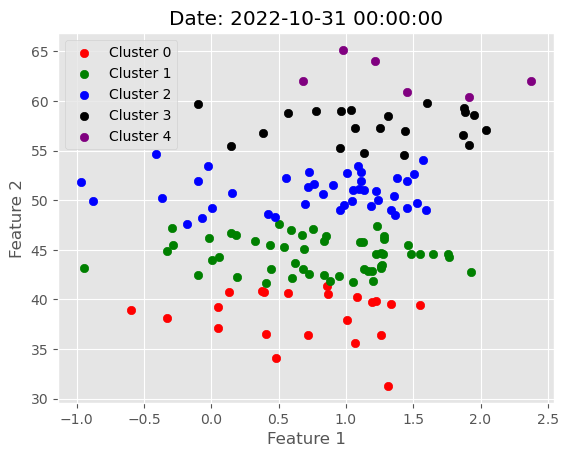

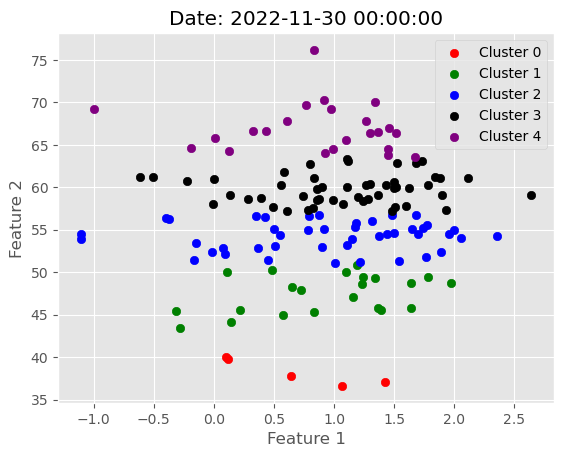

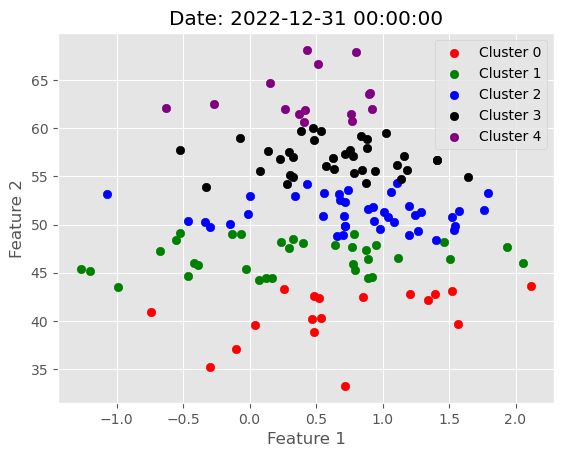

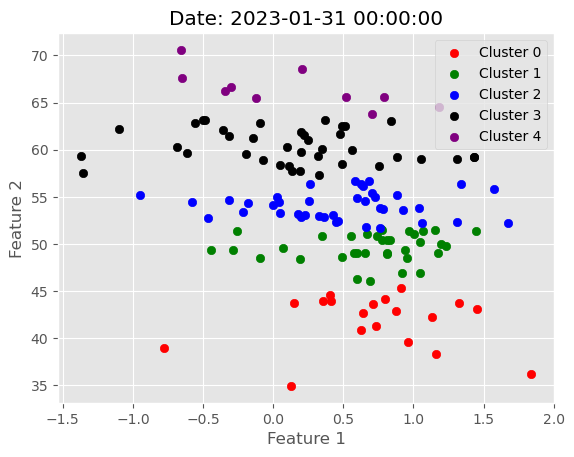

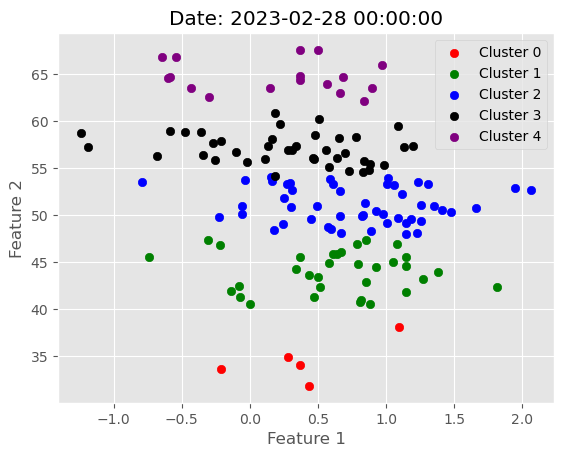

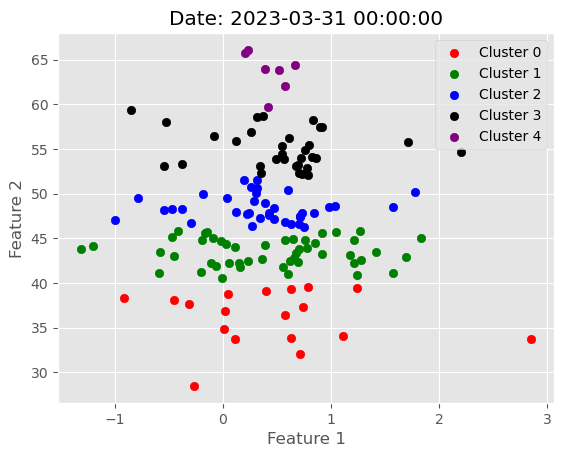

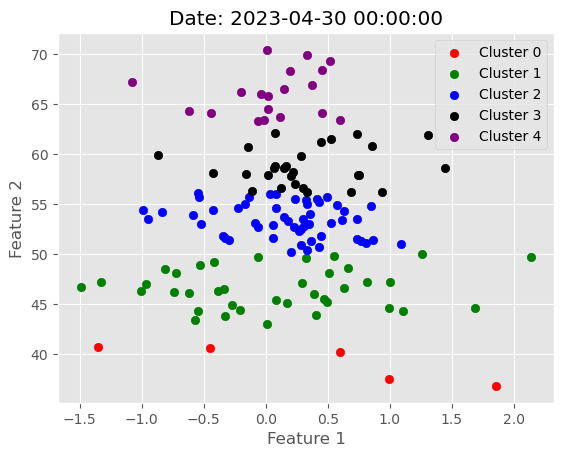

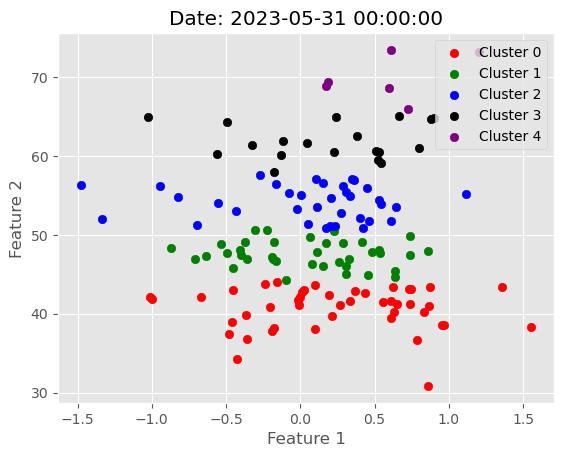

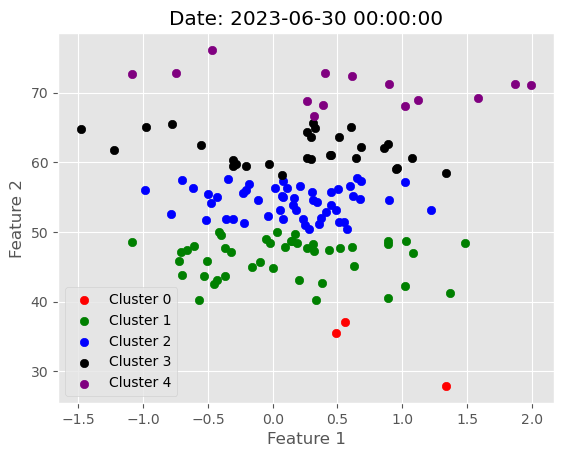

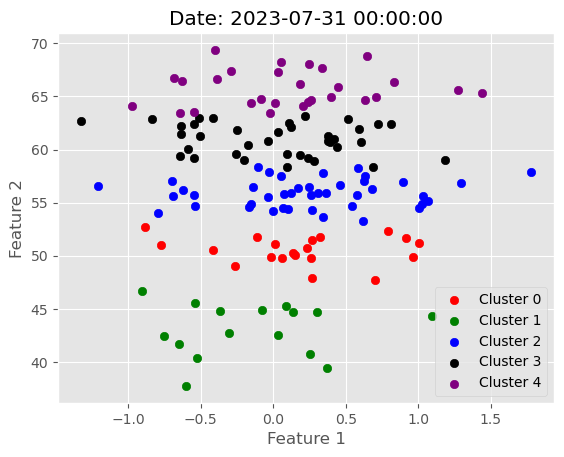

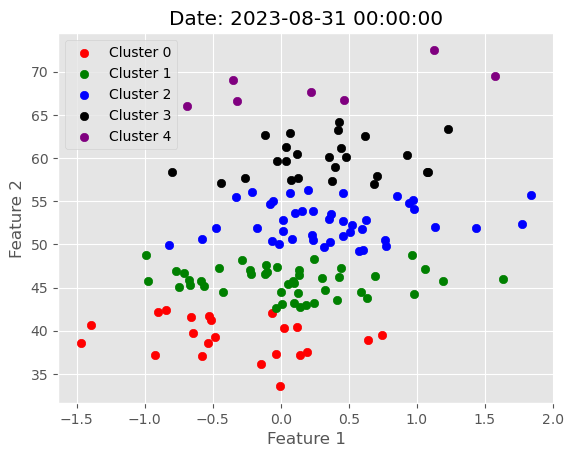

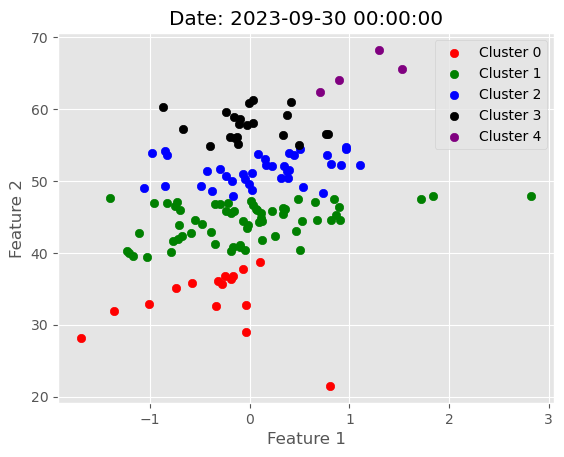

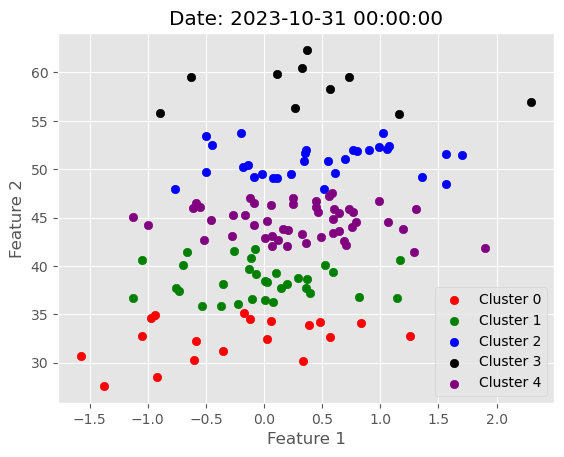

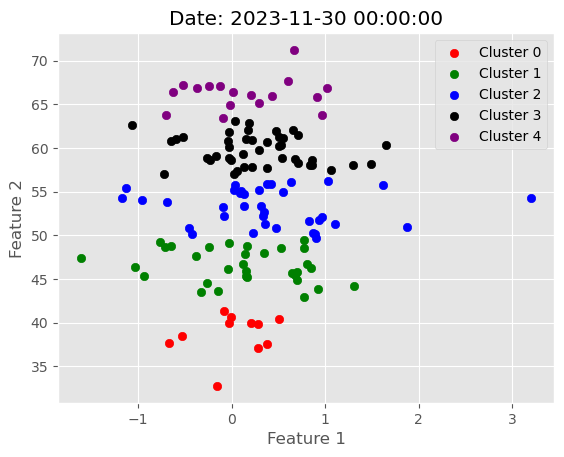

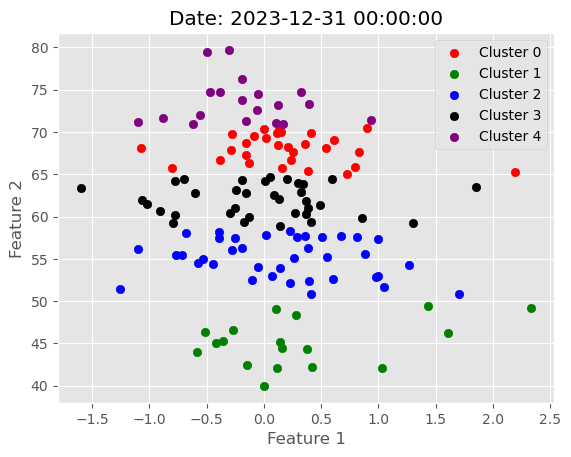

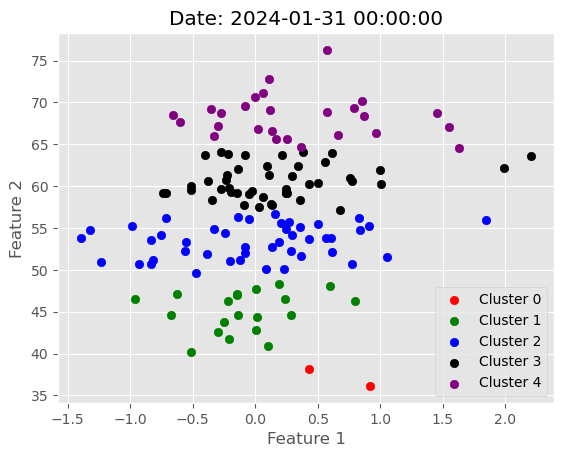

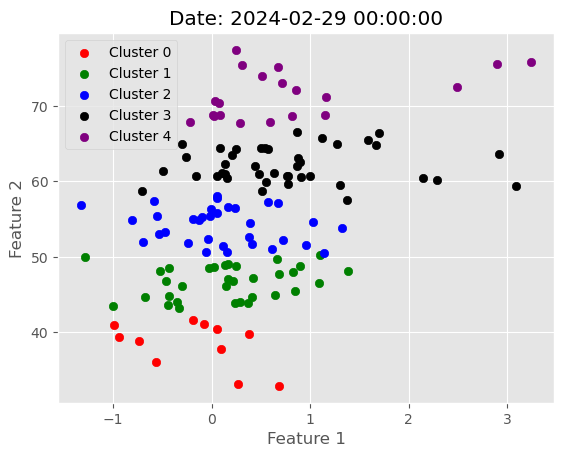

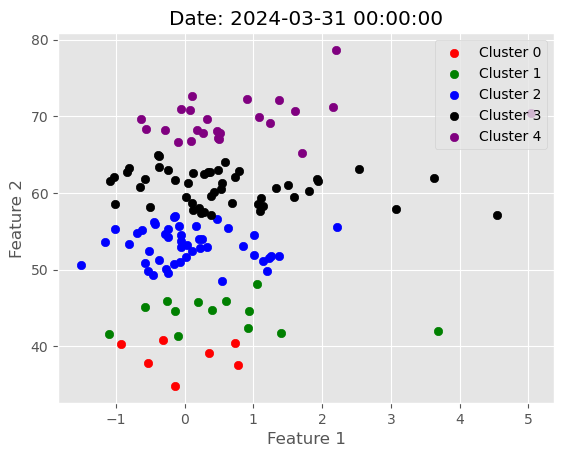

In [391]:
import matplotlib.pyplot as plt
# Iterate through each unique date and plot clusters for that date
# The plot title includes the specific date for each iteration

plt.style.use('ggplot')

for i in data.index.get_level_values('Date').unique().tolist():
    g = data.xs(i, level=0)
    plt.figure()
    plt.title(f'Date: {i}')  # Set the title to include the actual date
    plot_clusters(g)
    plt.show()


### Here the clustering isnt working so well since there is a lot of overlap and it is difficult to identiy distinct clusters. So we will try to help it by identifying and applying pre defined centroids.

In [383]:
# Define initial centroids for KMeans clustering, targeting specific RSI values
# The centroids are initialized with the target RSI values in the second column (index 1)

target_rsi_values = [30, 45, 55, 60, 70]
initial_centroids = np.zeros((len(target_rsi_values),18))
initial_centroids[:, 1] = target_rsi_values
initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 60.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

# Stock Selection Based on Clustering
Each month, I will select assets from a specific cluster and construct a portfolio using Efficient Frontier optimization to maximize the Sharpe ratio. First, I will filter stocks that belong to a chosen cluster based on a predefined hypothesis. Since momentum tends to persist, my hypothesis is that stocks clustered around an RSI 70 centroid are likely to outperform in the following month. Therefore, I will select stocks from cluster 4.

In [409]:
# Filter data for cluster 4 and adjust the dates to create a shifted index
# Create a dictionary where keys are dates and values are the list of tickers for each date

filtered_df = data[data['clusters'] == 4]
filtered_df = filtered_df.reset_index(level = 1)
filtered_df.index = filtered_df.index+pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['Date','Ticker'])
dates = filtered_df.index.get_level_values('Date').unique().tolist()
fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

#fixed_dates

{'2017-06-01': ['AAPL',
  'ADBE',
  'AMAT',
  'AMZN',
  'CTSH',
  'EA',
  'EXPE',
  'GOOG',
  'GOOGL',
  'ISRG',
  'MAR',
  'MCD',
  'NXPI',
  'PYPL',
  'RTX',
  'TMO',
  'WMT'],
 '2017-07-01': ['ABBV',
  'ABT',
  'BA',
  'CTSH',
  'DE',
  'ELV',
  'FDX',
  'ISRG',
  'JNJ',
  'KO',
  'MCD',
  'MDT',
  'MMM',
  'MO',
  'NEE',
  'NVDA',
  'PYPL',
  'REGN',
  'TSLA',
  'UNH'],
 '2017-08-01': ['AXP', 'BA', 'GILD', 'ORCL', 'STZ'],
 '2017-09-01': ['BA', 'CAT', 'CHTR', 'LMT', 'NEE', 'NXPI', 'PG', 'UNH', 'V'],
 '2017-10-01': ['ABBV',
  'ABT',
  'ACN',
  'AMGN',
  'BA',
  'BIIB',
  'BMY',
  'BSX',
  'CAT',
  'COP',
  'CVX',
  'DLTR',
  'EBAY',
  'F',
  'GILD',
  'GM',
  'ISRG',
  'MA',
  'MU',
  'PFE',
  'PYPL',
  'TMO',
  'UNP',
  'UPS',
  'VLO'],
 '2017-11-01': ['ABBV',
  'AMAT',
  'AXP',
  'BA',
  'BAC',
  'CAT',
  'DE',
  'DLTR',
  'F',
  'GM',
  'HD',
  'INTC',
  'ISRG',
  'JPM',
  'LRCX',
  'MA',
  'MAR',
  'MET',
  'MMM',
  'MSFT',
  'MU',
  'NOC',
  'NVDA',
  'NXPI',
  'PYPL',
  'SHW',


# Portfolio Optimization Function
Create a function that optimizes portfolio weights using the PyPortfolioOpt package's EfficientFrontier optimizer to maximize the Sharpe ratio. The function will take the past year's price data as input to determine the optimal weights for a portfolio. It will also apply constraints to ensure diversification, setting individual stock weight limits between half of the equally weighted allocation and a maximum of 10% of the total portfolio.

In [414]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
# Optimize portfolio weights using EfficientFrontier with a minimum weight bound
# SCS solver optimizes for the maximum Sharpe ratio while ensuring portfolio diversification

def optimise_weights(prices, lower_bound = 0):
    returns = expected_returns.mean_historical_return(prices, frequency=252)
    cov = risk_models.sample_cov(prices, frequency=252)
    ef = EfficientFrontier(returns, cov, weight_bounds=(lower_bound, .1), solver='SCS')
    weights = ef.max_sharpe()
    return ef.clean_weights()

# SCS: A linear programming solver used by the optimizer to solve for optimal weights.
# max_sharpe: This method optimizes the portfolio to achieve the maximum Sharpe ratio, balancing risk and return.
# clean_weights: This method rounds the optimized weights to remove very small allocations and make the weights more interpretable.
# lower bound adjustment ensures we have a diversified and well balanced portfolio

In [426]:
stocks = data.index.get_level_values('Ticker').unique().tolist()
#stocks

['AAL',
 'AAPL',
 'ABBV',
 'ABT',
 'ACN',
 'ADBE',
 'AIG',
 'AMAT',
 'AMGN',
 'AMZN',
 'AVGO',
 'AXP',
 'AZO',
 'BA',
 'BAC',
 'BIIB',
 'BKNG',
 'BMY',
 'BSX',
 'C',
 'CAT',
 'CHTR',
 'CMCSA',
 'CMG',
 'COP',
 'COST',
 'CRM',
 'CSCO',
 'CTSH',
 'CVS',
 'CVX',
 'DAL',
 'DD',
 'DE',
 'DG',
 'DIS',
 'DLTR',
 'EA',
 'EBAY',
 'ELV',
 'EOG',
 'EXPE',
 'F',
 'FCX',
 'FDX',
 'GE',
 'GILD',
 'GM',
 'GOOG',
 'GOOGL',
 'GS',
 'HAL',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'ISRG',
 'JNJ',
 'JPM',
 'KO',
 'KR',
 'LLY',
 'LMT',
 'LOW',
 'LUV',
 'MA',
 'MAR',
 'MCD',
 'MCK',
 'MDLZ',
 'MDT',
 'MET',
 'META',
 'MMM',
 'MO',
 'MRK',
 'MS',
 'MSFT',
 'MU',
 'NEM',
 'NFLX',
 'NKE',
 'NVDA',
 'NXPI',
 'ORCL',
 'ORLY',
 'OXY',
 'PANW',
 'PARA',
 'PEP',
 'PFE',
 'PG',
 'PM',
 'PYPL',
 'QCOM',
 'REGN',
 'RTX',
 'SBUX',
 'SCHW',
 'SLB',
 'STZ',
 'T',
 'TGT',
 'TJX',
 'TMO',
 'TSLA',
 'TXN',
 'UAL',
 'UNH',
 'UNP',
 'UPS',
 'USB',
 'V',
 'VLO',
 'VZ',
 'WBA',
 'WDC',
 'WFC',
 'WMT',
 'WYNN',
 'XOM',
 'GD',
 'HUM',
 '

In [436]:
# Download stock price data for the selected tickers, spanning 12 months before the first date in the dataset

new_df = yf.download(tickers = stocks, 
                     start = data.index.get_level_values('Date').unique()[0] - pd.DateOffset(months = 12),
                     end = data.index.get_level_values('Date').unique()[-1])
new_df

Price                      Adj Close                                      \
Ticker                           AAL        AAPL        ABBV        ABNB   
Date                                                                       
2016-05-31 00:00:00+00:00  30.666254   22.903511   44.191555         NaN   
2016-06-01 00:00:00+00:00  30.704693   22.582411   44.121338         NaN   
2016-06-02 00:00:00+00:00  30.435608   22.412680   45.708370         NaN   
2016-06-03 00:00:00+00:00  29.609127   22.458557   45.645168         NaN   
2016-06-06 00:00:00+00:00  30.041592   22.621399   44.114304         NaN   
...                              ...         ...         ...         ...   
2024-03-22 00:00:00+00:00  14.820000  171.847733  175.189529  167.860001   
2024-03-25 00:00:00+00:00  14.920000  170.421326  175.268066  167.990005   
2024-03-26 00:00:00+00:00  14.920000  169.284195  175.916016  167.389999   
2024-03-27 00:00:00+00:00  15.300000  172.875137  177.054840  166.410004   
2024-03-28 00:00:00+00:00  15.350000  171.049744  178.772842  164.960007   

Price                                                                      \
Ticker                            ABT         ACN        ADBE         ADI   
Date                                                                        
2016-05-31 00:00:00+00:00   34.024307  104.452652   99.470001   49.766502   
2016-06-01 00:00:00+00:00   33.912704  104.487770  100.040001   49.894096   
2016-06-02 00:00:00+00:00   33.938457  104.689697  100.169998   49.579342   
2016-06-03 00:00:00+00:00   33.637962  104.391205   98.699997   49.434727   
2016-06-06 00:00:00+00:00   33.629375  105.005783   99.120003   48.566990   
...                               ...         ...         ...         ...   
2024-03-22 00:00:00+00:00  109.443710  334.730255  499.519989  191.988235   
2024-03-25 00:00:00+00:00  108.889420  331.080475  507.230011  189.130890   
2024-03-26 00:00:00+00:00  110.364243  333.629395  507.600006  187.474030   
2024-03-27 00:00:00+00:00  112.324074  338.142029  504.399994  191.809662   
2024-03-28 00:00:00+00:00  112.502243  343.765472  504.600006  196.234573   

Price                                              ...   Volume           \
Ticker                            ADP        ADSK  ...        V      VLO   
Date                                               ...                     
2016-05-31 00:00:00+00:00   73.601837   58.270000  ...  8639600  6194400   
2016-06-01 00:00:00+00:00   73.836441   58.299999  ...  4507000  6355000   
2016-06-02 00:00:00+00:00   73.811317   58.759998  ...  5627500  5520900   
2016-06-03 00:00:00+00:00   73.174507   58.290001  ...  7628000  4541500   
2016-06-06 00:00:00+00:00   73.476128   58.669998  ...  7620100  5254700   
...                               ...         ...  ...      ...      ...   
2024-03-22 00:00:00+00:00  246.190857  262.859985  ...  8743000  3497100   
2024-03-25 00:00:00+00:00  242.800400  261.570007  ...  8519200  2767900   
2024-03-26 00:00:00+00:00  243.665421  261.670013  ...  8752400  3025300   
2024-03-27 00:00:00+00:00  246.906738  260.970001  ...  5190700  3098600   
2024-03-28 00:00:00+00:00  248.308655  260.420013  ...  5844400  3325900   

Price                                                                       \
Ticker                        VRTX        VZ       WBA       WDC       WFC   
Date                                                                         
2016-05-31 00:00:00+00:00  1741000  15834500   5007500   7898300  19725000   
2016-06-01 00:00:00+00:00  1433000  10670800   3916700   6583700  16774300   
2016-06-02 00:00:00+00:00  1295100   8721100   4018600   7597100  14206700   
2016-06-03 00:00:00+00:00  1473300   9500700   2488400   4941900  25452600   
2016-06-06 00:00:00+00:00  1259900  10075600   2621000   5782000  14528500   
...                            ...       ...       ...       ...       ...   
2024-03-22 00:00:00+00:00   821700  17815600   8219000   5438700  13736200   
2024-03-25 

## Calculate Daily Portfolio Returns
First, we will compute the daily returns for each stock in the portfolio. Then, for each month, we will select the stocks and calculate their optimized weights for the upcoming month. If the maximum Sharpe ratio optimization fails for a particular month, we will assign equal weights to all selected stocks as a fallback strategy.

In [583]:
# Calculate log returns for the 'Adj Close' prices
# Create an empty DataFrame to store portfolio returns
# Loop through each start_date from fixed_dates and define optimization period and end date
# Identify columns (stocks) for the selected start_date to form the optimization window
# Calculate optimization window for the past 12 months using historical data to optimize portfolio weights

# Attempt max Sharpe optimization for each month, but if it fails, fall back to equal weights strategy
# Extract stock returns for the given period between start_date and end_date
# Merge the calculated returns with optimized or equal weights to calculate weighted returns
# Group the weighted returns by date, then sum them to calculate the portfolio's overall strategy return
# Append the portfolio strategy return for the period to the portfolio_df


returns_df = np.log(new_df['Adj Close']).diff()
returns_df
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        # Define the start and end date
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        
        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(months=1)).strftime('%Y-%m-%d')
        optimization_df = new_df.loc[optimization_start_date:optimization_end_date, 'Adj Close'][cols]

        success = False
        try:
        # Optimize weights for the portfolio
            weights = optimise_weights(prices=optimization_df, lower_bound=round(1/(len(optimization_df.columns)*2), 3))
            weights = pd.DataFrame(weights, index=pd.Series(0))  # Ensure correct index for weights
            succes = True
        except: print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal Weights')
        # Extract returns for the given period
        temp_df = returns_df.loc[start_date:end_date]
        if success == False:
            weights = pd.DataFrame([1/(len(optimization_df.columns)) for i in range(len(optimization_df.columns))],
                                    index = optimization_df.columns.tolist(),
                                    columns = pd.Series(0)).T
        
        # Reset index, merge weights, and update temp_df
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
            .merge(weights.stack().to_frame('weights').reset_index(level=0, drop=True),
                   left_index=True,
                   right_index=True)\
            .reset_index()
        
        # Assuming the second level of index is named 'Ticker'
        temp_df = temp_df.set_index(['Date', 'Ticker']).unstack().stack()
        
        # Calculate weighted return
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weights']
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
    
        # Concatenate the result into the portfolio_df
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(f"Error processing for {start_date}: {e}")

        portfolio_df = portfolio_df.drop_duplicates()
        portfolio_df

Max Sharpe Optimization failed for 2017-08-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2017-09-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2018-06-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2018-07-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2019-02-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2019-06-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2019-11-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2020-05-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2020-06-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2020-07-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2020-10-01, Continuing with Equal Weights

<Axes: xlabel='Date'>

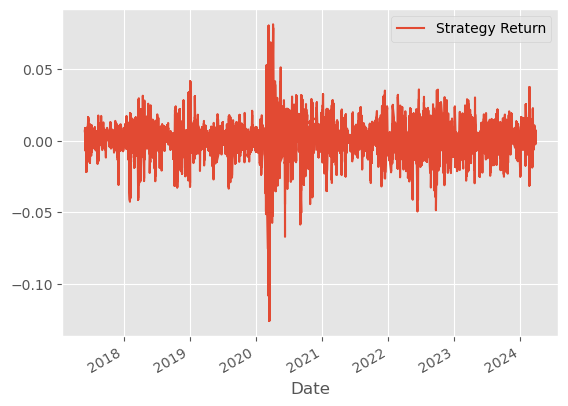

In [579]:
# Plot the portfolio's strategy returns over time
portfolio_df.plot()

In [555]:
# Calculate weighted returns for each asset and aggregate them into the final portfolio strategy returns
# Concatenate the result into the portfolio_df

temp_df['weighted_return'] = temp_df['return']*temp_df['weights']
temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
portfolio_df = pd.concat([portfolio_df,temp_df, axis = 0])

Strategy Return
Date                                      
2017-06-01 00:00:00+00:00         0.007156
2017-06-02 00:00:00+00:00         0.007985
2017-06-05 00:00:00+00:00        -0.002507
2017-06-06 00:00:00+00:00        -0.007870
2017-06-07 00:00:00+00:00         0.004966
2017-06-08 00:00:00+00:00        -0.000529
2017-06-09 00:00:00+00:00        -0.020760
2017-06-12 00:00:00+00:00        -0.010651
2017-06-13 00:00:00+00:00         0.008645
2017-06-14 00:00:00+00:00        -0.002553
2017-06-15 00:00:00+00:00        -0.004110
2017-06-16 00:00:00+00:00        -0.002999
2017-06-19 00:00:00+00:00         0.016103
2017-06-20 00:00:00+00:00        -0.004946
2017-06-21 00:00:00+00:00         0.006097
2017-06-22 00:00:00+00:00        -0.000971
2017-06-23 00:00:00+00:00         0.001940
2017-06-26 00:00:00+00:00        -0.005111
2017-06-27 00:00:00+00:00        -0.013596
2017-06-28 00:00:00+00:00         0.010879
2017-06-29 00:00:00+00:00        -0.015184
2017-06-30 00:00:00+00:00        -0.000201

## Visualize Returns Compared to S&P 500

In [600]:
# Download SPY price data and calculate SPY returns for buy and hold strategy
# Ensure both DataFrames have timezone-naive indexes before merging
# Merge portfolio strategy returns with SPY returns for comparison


spy =  yf.download(tickers = 'SPY',
                   start = '2015-01-01',
                   end = dt.date.today())
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close': 'SPY Buy and Hold'}, axis = 1)

#Ensure that both DataFrames have timezone-naive indexes
spy_ret.index = spy_ret.index.tz_localize(None)
portfolio_df.index = portfolio_df.index.tz_localize(None)
portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)
portfolio_df

Strategy Return  SPY Buy and Hold
Date                                         
2017-06-01         0.006376          0.007921
2017-06-02         0.008639          0.003323
2017-06-05        -0.002969         -0.000737
2017-06-06        -0.007334         -0.003202
2017-06-07         0.004809          0.001849
...                     ...               ...
2024-03-22        -0.002910         -0.001898
2024-03-25        -0.001156         -0.002767
2024-03-26        -0.000794         -0.001849
2024-03-27         0.007271          0.008369
2024-03-28        -0.001708         -0.000191

[3396 rows x 2 columns]

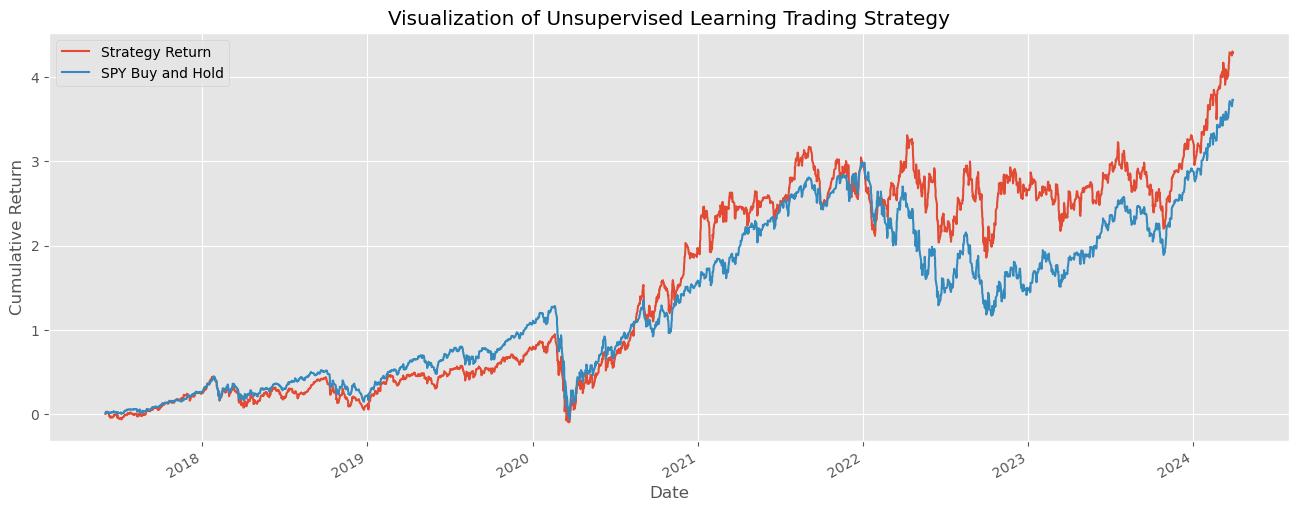

In [616]:
# Convert portfolio_df index to datetime, sort, and calculate cumulative returns
# Plot the cumulative return of both the strategy and SPY buy and hold strategy
# Set axis labels and chart title

import matplotlib.pyplot as plt
portfolio_df.index = pd.to_datetime(portfolio_df.index)
portfolio_df = portfolio_df.sort_index()
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()) - 1


ax = portfolio_cumulative_return.loc[:'2024-03-28'].plot(figsize=(16, 6))
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.set_title('Visualization of Unsupervised Learning Trading Strategy')
plt.show()
